# Wildfires in the Iberian Peninsula: Analysis, Investigation and Machine Learning Project

Wildfires are an increasingly severe consequence of climate change, with rising global temperatures and extreme weather events exacerbating fire frequency and intensity. This project aims to analyze historical wildfire patterns in the Iberian Peninsula using climate and fire data from 2000 onwards. By studying the three days leading up to each fire, I will explore the relationships between climate conditions, weather variability, and soil properties to identify key drivers of wildfire occurrences.

While the connection between climate change and extreme weather events is well established, this study seeks to analyze localized wildfire trends within a geologically similar region under two distinct governments—Portugal and Spain. This comparison will allow for an assessment of how differences in wildfire prevention policies impact fire frequency and severity.

Through this study, I hope to generate valuable insights that can be used to support sustainability efforts, environmental protection policies, and disaster preparedness strategies. By highlighting trends that may increase the potential for wildfires, this research aims to contribute to better resource allocation for government agencies, climate organizations, and policymakers. Ultimately, this project seeks to shed light on the broader impacts of global warming on ecosystems and communities.

***NOTE: This project in no way states that climate factors CAUSE a fire, however it will highlight conditions that enable wildfires to ocurr, as the existence and fueling of any fire relies on the weather and vegetation conditions that fuel it.***


In [1]:
import os
import gc
import re
import gc
import ast
import time
import glob
import cdsapi
import zipfile
import requests
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from dask.distributed import Client
from sklearn.preprocessing import MinMaxScaler
from shapely.geometry import Polygon, MultiPolygon
from concurrent.futures import ThreadPoolExecutor, as_completed
from eccodes import codes_grib_new_from_file, codes_get, codes_release





In [2]:
Data_Directory_Copernicus = "data\\historical\\Copernicus_Data"

## Data Sourcing

### Copernicus API Call

The following API call is commented out, as it won't be available without some preparation, and the time it takes for the data to download is **circa 60h.** The length of these requests is due to heavy usage worldwide as well as the complexity of the data being requested.

Sample of data downloaded is available in the below folder:

data\historical\Copernicus Data\cds_grib_data\zip_cdsapi_file_samples

API request details:

- Date Scope: 2000 to latest (Jan 2025), daily readings at specified times
- Variable Scope: All available variables with the exception of Snow and Lake datasets
- Location Scope: geographic area that covers Portugal, Spain, and respective island territories (Madeira, Azores, Canaries, Balearics)
- Time Scope: 08h, 12h, 17h, 21h, 23h

**Data Journey:**

- API Call downloads monthly data as .zip file
- Convert file from .zip to .grib
- Extract data from .grib file, re-arrange levels of variables across different editions, into a dataframe format
- Save dataframe to .parquet file
- Merge Copernicus data with FIRMS data

Full collection of .zip files is available on demand or via API call

Full collection of .grib files can be found in the following link: https://drive.google.com/drive/u/1/folders/1ANt0NaeU9-KgFFJ51cQ_cu_lyHL-DlZX

Full collection of .parquet files can be found in the following link: https://drive.google.com/drive/u/1/folders/143Xt9pca9DdIRqm3jBbGavr8MP8sQNRW

Full collection of iterative mergers between fire and weather data can be found in the following link: https://drive.google.com/drive/u/1/folders/1M-1Di-A1sWfwh6FvlBTb6erjnfgnSh-9



In [3]:
# # Initialize CDS API client
# client = cdsapi.Client()

# # Define dataset and static parameters
# dataset = "reanalysis-era5-land"

# # Define the range of years and months
# start_year = 2000
# end_year = 2025
# months = [f"{i:02d}" for i in range(1, 13)]

# # Define query parameters (except for year and month)
# base_request = {
#     "variable": [
#         "2m_dewpoint_temperature",
#         "2m_temperature",
#         "skin_temperature",
#         "soil_temperature_level_1",
#         "soil_temperature_level_2",
#         "soil_temperature_level_3",
#         "soil_temperature_level_4",
#         "volumetric_soil_water_layer_1",
#         "volumetric_soil_water_layer_2",
#         "volumetric_soil_water_layer_3",
#         "volumetric_soil_water_layer_4",
#         "surface_pressure",
#         "total_precipitation",
#         "evaporation_from_vegetation_transpiration",
#         "total_evaporation",
#         "potential_evaporation",
#         "surface_solar_radiation_downwards",
#         "surface_net_solar_radiation",
#         "surface_sensible_heat_flux",
#         "10m_u_component_of_wind",
#         "10m_v_component_of_wind",
#         "wind_gusts_10m_max",
#         "surface_runoff",
#         "leaf_area_index_high_vegetation",
#         "leaf_area_index_low_vegetation",
#         "land_sea_mask",
#         "type_of_high_vegetation",
#         "type_of_low_vegetation"
#     ],
#     "day": [f"{i:02d}" for i in range(1, 32)],  # All possible days
#     "time": ["08:00", "12:00", "17:00", "21:00", "23:00"],
#     "data_format": "grib",  # Keep GRIB format
#     "area": [44, -33, 29, 5]  # Bounding box
# }

# # Output directory for GRIB files
# output_dir = Data_Directory_Copernicus + "\zip_cdsapi_file_samples"
# os.makedirs(output_dir, exist_ok=True)

# # Function to fetch and save GRIB data for a given year and month
# def fetch_era5_grib(year, month):
#     request = base_request.copy()
#     request["year"] = str(year)
#     request["month"] = [month]

#     # Define output filename
#     grib_filename = os.path.join(output_dir, f"era5_land_{year}_{month}.grib")

#     try:
#         print(f"Downloading data for {year}-{month}...")

#         # Retrieve and save GRIB file
#         result = client.retrieve(dataset, request)
#         result.download(grib_filename)

#         print(f"Data for {year}-{month} saved as {grib_filename}.")
#         return grib_filename

#     except Exception as e:
#         print(f"Failed to download data for {year}-{month}: {e}")
#         return None

# # Use ThreadPoolExecutor to run multiple requests in one go
# max_workers = 4  # CDSAPI has a limitation of max 4 concurrent calls at one time

# # List of all year-month combinations for tracking progress
# tasks = [(year, month) for year in range(start_year, end_year + 1) for month in months]

# with ThreadPoolExecutor(max_workers=max_workers) as executor:
#     futures = {executor.submit(fetch_era5_grib, year, month): (year, month)
#                for year, month in tasks}

#     for future in as_completed(futures):
#         year, month = futures[future]
#         try:
#             future.result()
#         except Exception as e:
#             print(f"Error retrieving data for {year}-{month}: {e}")

# print("All GRIB data successfully retrieved and stored in", output_dir)


### Sample API Output

2025-02-01 00:15:06,630 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.

2025-02-01 00:15:06,630 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.

Downloading data for 2000-01...

Downloading data for 2000-02...

Downloading data for 2000-03...

Downloading data for 2000-04...

Downloading ERA5 GRIB Data:   0%|          | 0/312 [00:00<?, ?it/s]2025-02-01 00:15:06,897 INFO Request ID is 

1818f79f-4ace-403b-9b21-5734a466c343

2025-02-01 00:15:06,897 INFO Request ID is 85b0c0ad-ba9b-4b18-bc1b-076288005074

2025-02-01 00:15:06,968 INFO status has been updated to accepted

2025-02-01 00:15:06,968 INFO Request ID is fd4c19b1-7acc-487b-a939-7d200e7089b1

2025-02-01 00:15:06,974 INFO status has been updated to accepted

2025-02-01 00:15:06,979 INFO Request ID is 69f45a63-b238-4c74-857d-c7b285803313

2025-02-01 00:15:07,042 INFO status has been updated to accepted

2025-02-01 00:15:07,048 INFO status has been updated to accepted

### Extraction of .GRIB Files from ZIP archive

The below code is only processing a small number of .zip files from the API call, since the total number of files used for this databank is 294 files.

In order to showcase the functionality of the code, I have three .zip files from the API call we will use in the following step

In [4]:
zip_folder_path = Data_Directory_Copernicus + "\\zip_cdsapi_file_samples"
extracted_folder_path = Data_Directory_Copernicus + "\\extracted_grib_files_samples"

# Ensure the extracted folder exists
os.makedirs(extracted_folder_path, exist_ok=True)

# Loop through each ZIP file and extract the contents
for zip_filename in os.listdir(zip_folder_path):
    if zip_filename.endswith(".zip"):
        zip_path = os.path.join(zip_folder_path, zip_filename)
        zip_name = os.path.splitext(zip_filename)[0]  # Get ZIP file name without extension

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            for grib_file in zip_ref.namelist():
                if grib_file.endswith(".grib"):  # Only extract GRIB files
                    extracted_path = os.path.join(extracted_folder_path, f"{zip_name}_{grib_file}")
                    
                    with zip_ref.open(grib_file) as source, open(extracted_path, "wb") as target:
                        target.write(source.read())

                    print(f"Extracted: {grib_file} -> {zip_name}_{grib_file}")

print("\nAll ZIP files extracted successfully with original file names")


Extracted: data.grib -> era5_land_2024_08_data.grib
Extracted: data.grib -> era5_land_2024_09_data.grib
Extracted: data.grib -> era5_land_2024_10_data.grib

All ZIP files extracted successfully with original file names


### Extracting the variables from .GRIB

Due to the nature of .GRIB files, the data isn't readily available to read.

.GRIB files are used for meterological and geographical data, so they are stored in multiple levels and editions within the same file.

The below code extracts the variables iterating over level, and edition. The below code is commented out, as the data within .GRIB files is very large, and extracting it takes time - even with only a couple of samples.

You can run the below code to test its functionality, however please expect a running time of roughly 20 minutes in local (dependant on RAM) - faster if you are running this code in Google Colabs

In [5]:
# parquet_output_folder = os.path.join(Data_Directory_Copernicus, "parquet_output_samples")
# os.makedirs(parquet_output_folder, exist_ok=True)  # Ensure output folder exists

# # Function to extract unique variables from a GRIB file
# def get_unique_variables(grib_file):
#     variables = set()
#     with open(grib_file, "rb") as f:
#         while True:
#             gid = codes_grib_new_from_file(f)
#             if gid is None:
#                 break  # End of file
#             try:
#                 param = codes_get(gid, "shortName")
#                 edition = codes_get(gid, "edition")
#                 level_type = codes_get(gid, "typeOfLevel")
#                 variables.add((param, edition, level_type))
#             except Exception as e:
#                 print(f"Error: {e}")
#             finally:
#                 codes_release(gid)
#     return sorted(list(variables))  # Sorted for consistency

# # Process all GRIB files in the folder
# for file in sorted(os.listdir(extracted_folder_path)):
#     if file.endswith(".grib"):
#         file_path = os.path.join(extracted_folder_path, file)
#         idx_file = f"{file_path}.idx"  # Expected index file path

#         print(f"Processing: {file}")

#         # Check and recreate .idx file if missing/corrupted
#         if os.path.exists(idx_file):
#             try:
#                 with open(idx_file, "rb") as f:
#                     f.read()  # Try to read the index file
#             except (EOFError, OSError):
#                 print(f"Corrupt index detected, deleting {idx_file} and recreating...")
#                 os.remove(idx_file)  # Delete corrupted index file

#         # Extract year and month from filename (e.g., era5_land_2001_01.grib)
#         match = re.search(r"(\d{4})_(\d{2})", file)
#         if not match:
#             print(f"Skipping {file}, could not extract year and month")
#             continue
#         file_year, file_month = match.groups()

#         # Detect available variables
#         variables = get_unique_variables(file_path)
#         print(f"Detected {len(variables)} variables in {file}: {[v[0] for v in variables]}")

#         # Initialize empty DataFrame
#         combined_df = None

#         for var, edition, level_type in variables:
#             try:
#                 # Load dataset for this variable (this will recreate the .idx if missing)
#                 ds = xr.open_dataset(
#                     file_path,
#                     engine="cfgrib",
#                     backend_kwargs={"filter_by_keys": {"shortName": var, "edition": edition}},
#                     decode_timedelta=False
#                 )

#                 # Convert to DataFrame
#                 df = ds.to_dataframe().reset_index()

#                 # Drop duplicate non-variable columns before merging
#                 drop_cols = ["number", "surface", "valid_time", "depthBelowLandLayer"]
#                 df.drop(columns=[col for col in drop_cols if col in df.columns], errors="ignore", inplace=True)

#                 # Set index to (latitude, longitude, time, step)
#                 df.set_index(["latitude", "longitude", "time", "step"], inplace=True)

#                 # Rename the variable column
#                 df.rename(columns={var: f"{var}"}, inplace=True)

#                 # Merge into combined DataFrame for this month
#                 if combined_df is None:
#                     combined_df = df
#                 else:
#                     combined_df = combined_df.join(df, how="outer")

#                 print(f"Processed {var} (Edition {edition}), shape: {df.shape}")

#                 # Free memory
#                 del ds, df
#                 gc.collect()

#             except Exception as e:
#                 print(f"Skipping {var} in {file}: {e}")

#         # Save monthly Parquet file
#         if combined_df is not None:
#             output_file = os.path.join(parquet_output_folder, f"{file_year}_{file_month}.parquet")
#             combined_df.to_parquet(output_file, engine="pyarrow", compression="snappy")
#             print(f"Saved {output_file} with shape {combined_df.shape}")
#             del combined_df
#             gc.collect()



## Data Cleaning & Pre-Processing

Now lets investigate the file to see if there is any particular data cleaning and transformation needed.

I will examine the Copernicus data first as it is the largest set.

### Copernicus Data Cleaning and Transformation

There are 294 files, so will carry out data checks on one file.

In [6]:
parquet_output_folder = os.path.join(Data_Directory_Copernicus, "parquet_output_samples")
file = "2024_08.parquet"

def check_parquet_file(folder, file):
    parquet_file = os.path.join(folder, file)
    parquet_preview = dd.read_parquet(parquet_file, engine="pyarrow")

    print(f"Parquet file columns:\n{parquet_preview.columns}")

    # Print Data Types
    print("\nColumn Data Types:")
    column_dtypes = parquet_preview.dtypes  # Compute to get actual types
    display(column_dtypes)

    # Check for Unexpected Data Types (Example: If numeric columns contain strings)
    for col, dtype in column_dtypes.items():
        if dtype == "object":  # Object dtype could indicate mixed types or strings in numeric columns
            display(f"Column '{col}' is object/string but might contain numeric data!")

    print(f"\nData Preview:")
    display(parquet_preview.dropna(how="all").head(10))

    total_rows = parquet_preview.shape[0]
    print(f"\nTotal number of rows: {total_rows.compute()}")

    null_row_count = parquet_preview.isna().all(axis=1).sum().compute()
    print(f"\nNumber of rows with complete null rows: {null_row_count}")

    del parquet_preview
    gc.collect() 

check_parquet_file(parquet_output_folder, file)


Parquet file columns:
Index(['u10', 'v10', 'd2m', 't2m', 'e', 'evavt', 'lai_hv', 'lai_lv', 'pev',
       'skt', 'sp', 'sro', 'sshf', 'ssr', 'ssrd', 'stl1', 'stl2', 'stl3',
       'stl4', 'swvl1', 'swvl2', 'swvl3', 'swvl4', 'tp'],
      dtype='object')

Column Data Types:


u10       float32
v10       float32
d2m       float32
t2m       float32
e         float32
evavt     float32
lai_hv    float32
lai_lv    float32
pev       float32
skt       float32
sp        float32
sro       float32
sshf      float32
ssr       float32
ssrd      float32
stl1      float32
stl2      float32
stl3      float32
stl4      float32
swvl1     float32
swvl2     float32
swvl3     float32
swvl4     float32
tp        float32
dtype: object


Data Preview:


u10       v10         d2m  \
latitude longitude time                step                                   
29.0     -13.7     2024-08-01 00:00:00 8.0  -4.421997 -8.344391  292.593750   
                                       12.0 -3.643677 -8.578064  292.223389   
                                       17.0 -2.543381 -8.395493  292.955078   
                                       21.0 -3.046997 -9.207199  293.416504   
                                       23.0 -3.881653 -9.437546  293.362549   
                   2024-08-01 08:00:00 0.0        NaN       NaN         NaN   
                   2024-08-01 12:00:00 0.0        NaN       NaN         NaN   
                   2024-08-01 17:00:00 0.0        NaN       NaN         NaN   
                   2024-08-01 21:00:00 0.0        NaN       NaN         NaN   
                   2024-08-01 23:00:00 0.0        NaN       NaN         NaN   

                                                    t2m         e     evavt  \
latitude longitude time                step                                   
29.0     -13.7     2024-08-01 00:00:00 8.0   295.225830 -0.000003 -0.000001   
                                       12.0  296.760742 -0.000022 -0.000002   
                                       17.0  296.895752 -0.000052 -0.000002   
                                       21.0  295.537109 -0.000056 -0.000002   
                                       23.0  295.189209 -0.000057 -0.000003   
                   2024-08-01 08:00:00 0.0          NaN       NaN       NaN   
                   2024-08-01 12:00:00 0.0          NaN       NaN       NaN   
                   2024-08-01 17:00:00 0.0          NaN       NaN       NaN   
                   2024-08-01 21:00:00 0.0          NaN       NaN       NaN   
                   2024-08-01 23:00:00 0.0          NaN       NaN       NaN   

                                             lai_hv  lai_lv       pev  \
latitude longitude time                step                             
29.0     -13.7     2024-08-01 00:00:00 8.0      0.0     0.0 -0.000385   
                                       12.0     0.0     0.0 -0.002540   
                                       17.0     0.0     0.0 -0.006090   
                                       21.0     0.0     0.0 -0.006759   
                                       23.0     0.0     0.0 -0.006869   
                   2024-08-01 08:00:00 0.0      NaN     NaN       NaN   
                   2024-08-01 12:00:00 0.0      NaN     NaN       NaN   
                   2024-08-01 17:00:00 0.0      NaN     NaN       NaN   
                   2024-08-01 21:00:00 0.0      NaN     NaN       NaN   
                   2024-08-01 23:00:00 0.0      NaN     NaN       NaN   

                                                    skt  ...        ssrd  \
latitude longitude time                step              ...               
29.0     -13.7     2024-08-01 00:00:00 8.0          NaN  ...    604478.0   
                                       12.0         NaN  ...   8555536.0   
                                       17.0         NaN  ...  22767948.0   
                                       21.0         NaN  ...  24900518.0   
                                       23.0         NaN  ...  24900518.0   
                   2024-08-01 08:00:00 0.0   296.056885  ...         NaN   
                   2024-08-01 12:00:00 0.0   309.998535  ...         NaN   
                   2024-08-01 17:00:00 0.0   310.695557  ...         NaN   
                   2024-08-01 21:00:00 0.0   296.829346  ...         NaN   
                   2024-08-01 23:00:00 0.0   295.174805  ...         NaN   

                                                   stl1        stl2  \
latitude longitude time                step                           
29.0     -13.7     2024-08-01 00:00:00 8.0          NaN         NaN   
                                       12.0         NaN         NaN   
                                       17.0         NaN         NaN   
       


Total number of rows: 17834610

Number of rows with complete null rows: 12720540


Immediately we can see that there are some data **inconsistencies**:

- Column names are abbreviated and not clear
- In the Multi-Index:
  - Dates are stored under "time" and they include a timestamp
  - Step is where the times are stored, but some state "0.0" and the time can be seen in the "time" column
  - There is a very large number of null rows - Copernicus weather data is extracted as a big grid over a very large area, so many of these latitudes and longitudes might not have a reading.
  - Variables seem to be misaligned horizontally, a sub-set of rows that cover one date have some variables null in the first four rows, and populated in the following 4 rows. This may also account for some of the NULL counts. When appending the Copernicus data to the FIRMS data, will need to account for this, in order to fix the misalignment.

**Steps to take:**
- Reset index so we can manipulate and transform the data within it.
- Drop any rows where completely null
- Rename "time" to "date"
- Rename "step" to "time"
- Where "step" (renamed to "time") is 0.0, extract the time from the "time" (renamed to "date") column
- Remove all timestamps from the "time" (renamed to "date") column
- Drop any rows that are for 23h - this is to save on memory and computational power as it's not as relevant as some of the other times.
- Forward Fill the Latitude and Longitude Columns
- Round Latitude and Longitude to 1 decimal point. They already appear to be 1 decimal point, but want to ensure it's forced in case there are exceptions.


I will tackle the renaming of the columns once the weather data is merged with the fire dataset in order to save computational power. If I rename it at this stage I will be renaming all 294 files. If I wait until the data is merged, I will be renaming one file only.

In [7]:
# Paths
cleaned_folder = "data\\cleaned\\Copernicus_Cleaned_Data\\cleaned_parquet_samples"
os.makedirs(cleaned_folder, exist_ok=True)  

# Get List of Parquet Files
parquet_files = glob.glob(os.path.join(parquet_output_folder, "*.parquet"))

# Function to Clean Parquet Data
def clean_parquet(file):
    print(f"Cleaning: {file}")

    # Load parquet file with Dask for fast processing
    parquet_to_clean = dd.read_parquet(file, engine="pyarrow")

    # Reset index to bring 'time' (date values) into columns
    parquet_to_clean = parquet_to_clean.reset_index()

    # Ensure 'time' is datetime format & rename column
    if "time" in parquet_to_clean.columns:
        parquet_to_clean = parquet_to_clean.rename(columns={"time": "date"})  # Rename 'time' to 'date'

    # Ensure latitude & longitude are populated
    parquet_to_clean["latitude"] = parquet_to_clean["latitude"].ffill()
    parquet_to_clean["longitude"] = parquet_to_clean["longitude"].ffill()

    # Ensure every row has a date
    parquet_to_clean["date"] = parquet_to_clean["date"].ffill()

    # Rename 'time' to step
    if "step" in parquet_to_clean.columns:
        parquet_to_clean = parquet_to_clean.rename(columns={"step": "time"})  # Rename 'step' to 'time'

    # Convert to Pandas for '.dt' operations
    parquet_to_clean = parquet_to_clean.compute()

    # Convert 'date' to datetime format
    parquet_to_clean["date"] = pd.to_datetime(parquet_to_clean["date"], errors="coerce")

    # Extract the hour from the 'date' column and assign it to 'time' where time is 0.0
    parquet_to_clean.loc[parquet_to_clean["time"] == 0.0, "time"] = parquet_to_clean["date"].dt.hour.astype(float)

    # Remove time from the 'date' column, keeping only YYYY-MM-DD
    parquet_to_clean["date"] = parquet_to_clean["date"].dt.date

    # Drop rows where all values (except indexes) are NaN
    parquet_to_clean = parquet_to_clean.dropna(how="all", subset=parquet_to_clean.columns.difference(["latitude", "longitude", "date", "time"]))

    # Drop rows where 'time' is 23h
    parquet_to_clean = parquet_to_clean[parquet_to_clean["time"] != 23.0]

    # Round Latitude & Longitude to 1 decimal places - they appear to already be 1 decimal place but just in case it's purely visual
    parquet_to_clean["latitude"] = parquet_to_clean["latitude"].round(1)
    parquet_to_clean["longitude"] = parquet_to_clean["longitude"].round(1)

    # Save cleaned Parquet file using PyArrow (optimized for fast read/write)
    cleaned_path = os.path.join(cleaned_folder, os.path.basename(file))
    parquet_to_clean.to_parquet(cleaned_path, engine="pyarrow", compression="snappy", index=False)

    print(f"Cleaned file saved: {cleaned_path}")
    
    # Force garbage collection and delete temp variable
    del parquet_to_clean
    gc.collect()

    return cleaned_path

# Process & Clean All Parquet Files (Parallelized with Dask)
cleaned_files = [clean_parquet(file) for file in parquet_files]

print(f"All Parquet files cleaned and saved in: {cleaned_folder}")

del parquet_files
del cleaned_files
gc.collect()


Cleaning: data\historical\Copernicus_Data\parquet_output_samples\2024_08.parquet
Cleaned file saved: data\cleaned\Copernicus_Cleaned_Data\cleaned_parquet_samples\2024_08.parquet
Cleaning: data\historical\Copernicus_Data\parquet_output_samples\2024_09.parquet
Cleaned file saved: data\cleaned\Copernicus_Cleaned_Data\cleaned_parquet_samples\2024_09.parquet
Cleaning: data\historical\Copernicus_Data\parquet_output_samples\2024_10.parquet
Cleaned file saved: data\cleaned\Copernicus_Cleaned_Data\cleaned_parquet_samples\2024_10.parquet
All Parquet files cleaned and saved in: data\cleaned\Copernicus_Cleaned_Data\cleaned_parquet_samples


0

Check Parquet file after cleaning (the same file checked before) to identify the differences

In [8]:
check_parquet_file(cleaned_folder, file)

Parquet file columns:
Index(['latitude', 'longitude', 'date', 'time', 'u10', 'v10', 'd2m', 't2m',
       'e', 'evavt', 'lai_hv', 'lai_lv', 'pev', 'skt', 'sp', 'sro', 'sshf',
       'ssr', 'ssrd', 'stl1', 'stl2', 'stl3', 'stl4', 'swvl1', 'swvl2',
       'swvl3', 'swvl4', 'tp'],
      dtype='object')

Column Data Types:


latitude                  float64
longitude                 float64
date         date32[day][pyarrow]
time                      float64
u10                       float32
v10                       float32
d2m                       float32
t2m                       float32
e                         float32
evavt                     float32
lai_hv                    float32
lai_lv                    float32
pev                       float32
skt                       float32
sp                        float32
sro                       float32
sshf                      float32
ssr                       float32
ssrd                      float32
stl1                      float32
stl2                      float32
stl3                      float32
stl4                      float32
swvl1                     float32
swvl2                     float32
swvl3                     float32
swvl4                     float32
tp                        float32
dtype: object


Data Preview:


,latitude,longitude,date,time,u10,v10,d2m,t2m,e,evavt,...,ssrd,stl1,stl2,stl3,stl4,swvl1,swvl2,swvl3,swvl4,tp
0,29.0,-13.7,2024-08-01,8.0,-4.421997,-8.344391,292.593750,295.225830,-0.000003,-1.005828e-06,...,604478.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000014
1,29.0,-13.7,2024-08-01,12.0,-3.643677,-8.578064,292.223389,296.760742,-0.000022,-1.542270e-06,...,8555536.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000033
2,29.0,-13.7,2024-08-01,17.0,-2.543381,-8.395493,292.955078,296.895752,-0.000052,-2.121553e-06,...,22767948.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000035
3,29.0,-13.7,2024-08-01,21.0,-3.046997,-9.207199,293.416504,295.537109,-0.000056,-2.492219e-06,...,24900518.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000035
4,29.0,-13.7,2024-08-01,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,296.427246,300.502686,299.741943,297.838867,0.011353,0.090271,0.077789,0.010605,NaN
5,29.0,-13.7,2024-08-01,12.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,306.887695,300.661621,299.745605,297.839355,0.011383,0.090271,0.077789,0.010605,NaN
6,29.0,-13.7,2024-08-01,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,309.304688,301.584229,299.759766,297.842041,0.010971,0.090271,0.077789,0.010605,NaN
7,29.0,-13.7,2024-08-01,21.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,298.973389,301.606934,299.776611,297.844727,0.010941,0.090271,0.077789,0.010605,NaN
8,29.0,-13.7,2024-08-02,8.0,-4.456436,-8.736191,292.348145,294.948486,-0.000004,-9.364448e-07,...,532274.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000037
9,29.0,-13.7,2024-08-02,12.0,-3.164825,-8.515808,293.004150,296.756104,-0.000026,-1.367182e-06,...,9684822.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000040



Total number of rows: 4091256

Number of rows with complete null rows: 0


### FIRMS Fire Data Cleaning and Transformation

First let's merge the three .JSON files extracted from the portal.

In [9]:
raw_fire_file_directory = ["data\\historical\\FIRMS_Fire_Data\\fire_archive_M-C61_571821.json",
    "data\\historical\\FIRMS_Fire_Data\\fire_archive_M-C61_571826.json",
    "data\\historical\\FIRMS_Fire_Data\\fire_archive_SV-C2_571830.json"]

fire_dataframes = [pd.read_json(file) for file in raw_fire_file_directory]

combined_fire_datarame = pd.concat(fire_dataframes, ignore_index=True)

combined_fire_datarame = combined_fire_datarame.copy()


Now let's verify some of the metrics of the data

In [10]:
def check_FIRMS_file(file):
    print("\nData Info:\n")
    print(file.info())
    print("\nData Preview:")
    display(file.head(5))
    print("\nColumn Names:\n")
    print(file.columns)

check_FIRMS_file(combined_fire_datarame)


Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373035 entries, 0 to 373034
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   latitude    373035 non-null  float64
 1   longitude   373035 non-null  float64
 2   acq_date    373035 non-null  object 
 3   acq_time    373035 non-null  int64  
 4   scan        373035 non-null  float64
 5   frp         373035 non-null  float64
 6   brightness  373035 non-null  float64
 7   confidence  373035 non-null  object 
 8   track       373035 non-null  float64
 9   type        373035 non-null  int64  
 10  satellite   373035 non-null  object 
 11  daynight    373035 non-null  object 
 12  bright_t31  373035 non-null  float64
 13  version     373035 non-null  float64
 14  instrument  373035 non-null  object 
dtypes: float64(8), int64(2), object(5)
memory usage: 42.7+ MB
None

Data Preview:


,latitude,longitude,acq_date,acq_time,scan,frp,brightness,confidence,track,type,satellite,daynight,bright_t31,version,instrument
0,39.4605,-8.5570,2000-11-06,1151,1.0,4.9,300.6,40,1.0,0,Terra,D,287.8,6.03,MODIS
1,37.7087,-7.7873,2000-11-08,1139,1.0,6.2,306.6,64,1.0,0,Terra,D,286.7,6.03,MODIS
2,37.6988,-7.7845,2000-11-08,1139,1.0,26.2,327.9,85,1.0,0,Terra,D,290.6,6.03,MODIS
3,32.7630,-17.2021,2001-02-13,2323,1.0,12.0,307.5,54,1.0,0,Terra,N,282.2,6.03,MODIS
4,41.4451,-7.6717,2001-02-19,1142,1.0,9.9,306.9,64,1.0,0,Terra,D,283.2,6.03,MODIS



Column Names:

Index(['latitude', 'longitude', 'acq_date', 'acq_time', 'scan', 'frp',
       'brightness', 'confidence', 'track', 'type', 'satellite', 'daynight',
       'bright_t31', 'version', 'instrument'],
      dtype='object')


Other than unclear column names, this dataset seems to be fairly consistent.
There are no null values, however the major concern is that some of the column types are "Object", indicating that there might be multiple dataypes within that column.

In [11]:
def inspect_object_columns(df):
    object_columns = df.select_dtypes(include=["object"]).columns  # Get object dtype columns
    
    print("\nAnalyzing Object Columns:\n")
    for col in object_columns:
        unique_types = df[col].apply(type).value_counts()
        print(f"Column: {col}")
        print(f"Unique Data Types in Column:")
        display(unique_types)
        
        # Show 5 random examples of each datatype found in the column
        print("\nSample Values by Data Type:")
        for dtype in unique_types.index:
            sample_values = df[df[col].apply(type) == dtype][col].sample(min(5, len(df)), random_state=42).tolist()
            display(f"   - {dtype}: {sample_values}")

        print("\n" + "-"*80 + "\n")

# Call the function to inspect object columns
inspect_object_columns(combined_fire_datarame)



Analyzing Object Columns:

Column: acq_date
Unique Data Types in Column:


acq_date
<class 'str'>    373035
Name: count, dtype: int64


Sample Values by Data Type:


"   - <class 'str'>: ['2017-08-23', '2013-09-23', '2013-09-28', '2003-08-02', '2019-11-27']"


--------------------------------------------------------------------------------

Column: confidence
Unique Data Types in Column:


confidence
<class 'str'>    199356
<class 'int'>    173679
Name: count, dtype: int64


Sample Values by Data Type:


"   - <class 'str'>: ['h', 'n', 'n', 'n', 'n']"

"   - <class 'int'>: [100, 50, 93, 41, 62]"


--------------------------------------------------------------------------------

Column: satellite
Unique Data Types in Column:


satellite
<class 'str'>    373035
Name: count, dtype: int64


Sample Values by Data Type:


"   - <class 'str'>: ['N', 'N', 'N', 'Aqua', 'N']"


--------------------------------------------------------------------------------

Column: daynight
Unique Data Types in Column:


daynight
<class 'str'>    373035
Name: count, dtype: int64


Sample Values by Data Type:


"   - <class 'str'>: ['N', 'N', 'D', 'N', 'N']"


--------------------------------------------------------------------------------

Column: instrument
Unique Data Types in Column:


instrument
<class 'str'>    373035
Name: count, dtype: int64


Sample Values by Data Type:


"   - <class 'str'>: ['VIIRS', 'VIIRS', 'VIIRS', 'MODIS', 'VIIRS']"


--------------------------------------------------------------------------------



Let's convert the object type columns to string, to minimize compatibility issues

In [12]:
# Convert all object columns to strings
object_columns = combined_fire_datarame.select_dtypes(include=["object"]).columns
combined_fire_datarame[object_columns] = combined_fire_datarame[object_columns].astype(str)

# Ensure 'confidence' column is also fully string-based
combined_fire_datarame["confidence"] = combined_fire_datarame["confidence"].astype(str)

Check for duplicates and remove them

In [13]:
duplicates_removed = combined_fire_datarame.drop_duplicates(subset=["latitude", "longitude", "acq_date"])
duplicates_count = combined_fire_datarame.shape[0]-duplicates_removed.shape[0]

if duplicates_count > 0:
    print(f"Duplicates entries with same lat, lon & date detected: {duplicates_count}")
    cleaned_fire_data = duplicates_removed
    print("Duplicates removed.")
else:
    print(f"No duplicates found")
    cleaned_fire_data = combined_fire_datarame

    cleaned_fire_data.info()


Duplicates entries with same lat, lon & date detected: 1
Duplicates removed.


Save the dataset to a .csv file

In [14]:
cleaned_fire_folder = "data\\cleaned\\FIRMS_Fire_Cleaned_Data\\historical_fire_cleaned_data.csv"
cleaned_fire_data.to_csv(cleaned_fire_folder)

### Overpass Data Cleaning and Transformation

Through the EDA phase of this project, it came to light that within the FIRMS data, some fire labelled as Fire_Type 0 (Presumed Vegetation Fire) actually display coordinates for industrial estates, factories, power plants and more.

To minimize the skeweing of this mislabelling, I have sourced data from Overpass turbo in order to extract the coordinates of these locations.

Some vegetation fire records may be lost in this process, if they ocurr close to one of these areas, but it is preferable to have some record loss if it increases the accuracy of fire records being used in this analysis that are true Vegetation fires (Wildfires).

The files were downloaded directly from Overpass as geojson files and saved under 'data/factory_locations

Queries used in the Overpass terminal in order to source the files:

```
[out:json][timeout:60];
// Define Portugal using its boundary
{{geocodeArea:Portugal}}->.searchArea;

// Find all industrial buildings, factories, and industrial estates
(
  node["landuse"="industrial"](area.searchArea);
  node["industrial"="industry"](area.searchArea);
  node["industrial"="industrial_area"](area.searchArea);
  node["man_made"="works"](area.searchArea);
  node["building"="industrial"](area.searchArea);
  way["landuse"="industrial"](area.searchArea);
  way["industrial"="industry"](area.searchArea);
  way["industrial"="industrial_area"](area.searchArea);
  way["man_made"="works"](area.searchArea);
  //way["building"="industrial"](area.searchArea);
  relation["landuse"="industrial"](area.searchArea);
  relation["industrial"="industry"](area.searchArea);
  relation["industrial"="industrial_area"](area.searchArea);
  relation["man_made"="works"](area.searchArea);
  relation["building"="industrial"](area.searchArea);
);

// Output results on the map
out body;
>;
out skel qt;
```

---------------------------------

```
[out:json][timeout:60];
// Define Spain using its boundary
{{geocodeArea:Spain}}->.searchArea;

// Find all industrial buildings, factories, and industrial estates
(
  node["landuse"="industrial"](area.searchArea);
  node["industrial"="industry"](area.searchArea);
  node["industrial"="industrial_area"](area.searchArea);
  node["man_made"="works"](area.searchArea);
  node["building"="industrial"](area.searchArea);
  way["landuse"="industrial"](area.searchArea);
  way["industrial"="industry"](area.searchArea);
  way["industrial"="industrial_area"](area.searchArea);
  way["man_made"="works"](area.searchArea);
  //way["building"="industrial"](area.searchArea);
  relation["landuse"="industrial"](area.searchArea);
  relation["industrial"="industry"](area.searchArea);
  relation["industrial"="industrial_area"](area.searchArea);
  relation["man_made"="works"](area.searchArea);
  relation["building"="industrial"](area.searchArea);
);

// Output results on the map
out body;
>;
out skel qt;
```

In [15]:
# Define file paths
portugal_geojson_path = "data\\factory_locations\\Portugal.geojson"
spain_geojson_path = "data\\factory_locations\\Spain.geojson"

# Load the full GeoJSON files
gdf_portugal = gpd.read_file(portugal_geojson_path)
gdf_spain = gpd.read_file(spain_geojson_path)

# Dynamically determine available columns
available_columns_portugal = set(gdf_portugal.columns)
available_columns_spain = set(gdf_spain.columns)

# Define relevant columns, including Spain-specific ones
desired_columns = [
    "geometry", "landuse", "building", "man_made", "amenity", "power",
    "industrial", "waste", "works", "working", "factory", "plant", "shop", "substation",
    # Spain-Specific Columns
    "was:industrial", "disused:industrial", "was:man_made", "was:shop"
]

# Filter only columns that exist in each dataset
columns_to_keep_portugal = ["geometry"] + [col for col in desired_columns if col in available_columns_portugal]
columns_to_keep_spain = ["geometry"] + [col for col in desired_columns if col in available_columns_spain]

# Select only existing columns
gdf_portugal = gdf_portugal[columns_to_keep_portugal]
gdf_spain = gdf_spain[columns_to_keep_spain]

# Function to filter industrial locations and extract coordinates
def get_coordinates(gdf):
    """Filters industrial-related locations and extracts coordinates, including Spain-specific tags."""

    # Ensure filtering only uses available columns
    conditions = []
    if "landuse" in gdf.columns:
        conditions.append(gdf["landuse"] == "industrial")
    if "building" in gdf.columns:
        conditions.append(gdf["building"].isin(["industrial", "factory", "warehouse", "plant"]))
    if "man_made" in gdf.columns:
        conditions.append(gdf["man_made"].isin(["works", "chimney", "storage_tank"]))
    if "amenity" in gdf.columns:
        conditions.append(gdf["amenity"] == "recycling")
    if "power" in gdf.columns:
        conditions.append(gdf["power"] == "plant")
    if "industrial" in gdf.columns:
        conditions.append(gdf["industrial"].notna())
    if "waste" in gdf.columns:
        conditions.append(gdf["waste"].isin(["recycling", "scrap_yard", "disposal"]))
    if "works" in gdf.columns:
        conditions.append(gdf["works"].notna())
    if "working" in gdf.columns:
        conditions.append(gdf["working"].notna())
    if "factory" in gdf.columns:
        conditions.append(gdf["factory"].notna())
    if "plant" in gdf.columns:
        conditions.append(gdf["plant"].notna())
    if "shop" in gdf.columns:
        conditions.append(gdf["shop"].notna())
    if "substation" in gdf.columns:
        conditions.append(gdf["substation"].notna())

    # Spain-Specific Filtering
    if "was:industrial" in gdf.columns:
        conditions.append(gdf["was:industrial"].notna())
    if "disused:industrial" in gdf.columns:
        conditions.append(gdf["disused:industrial"].notna())
    if "was:man_made" in gdf.columns:
        conditions.append(gdf["was:man_made"].notna())
    if "was:shop" in gdf.columns:
        conditions.append(gdf["was:shop"].notna())

    # Apply filtering dynamically based on available columns
    if conditions:
        industrial_filter = gdf[pd.concat(conditions, axis=1).any(axis=1)].copy()
    else:
        industrial_filter = gdf.copy()  # If no relevant columns exist, keep all

    # Ensure only one geometry column exists
    industrial_filter = industrial_filter.loc[:, ~industrial_filter.columns.duplicated()]

    # Ensure geometry column is valid and not empty
    if "geometry" in industrial_filter.columns:
        industrial_filter = industrial_filter.dropna(subset=["geometry"])

    # Function to extract coordinates safely
    def extract_coords(geom):
        """Extracts coordinates from valid Polygon and MultiPolygon geometries."""
        if geom is None or geom.is_empty:
            return None
        elif isinstance(geom, Polygon):
            return list(geom.exterior.coords)
        elif isinstance(geom, MultiPolygon):
            return [list(p.exterior.coords) for p in geom.geoms]
        return None

    # Apply function only on valid geometry objects
    if "geometry" in industrial_filter.columns:
        industrial_filter["coords"] = industrial_filter["geometry"].apply(
            lambda g: extract_coords(g) if isinstance(g, (Polygon, MultiPolygon)) else None
        )

    # Ensure "coords" column exists before exploding
    if "coords" in industrial_filter.columns:
        industrial_filter["coords"] = industrial_filter["coords"].fillna("").astype(str)  # Prevent NaN issues
        industrial_filter = industrial_filter.explode("coords", ignore_index=True)

    # Ensure geometry column is completely dropped after extraction
    industrial_filter = industrial_filter.drop(columns=["geometry"], errors="ignore")

    return industrial_filter  

# Apply function to extract coordinates
gdf_portugal = get_coordinates(gdf_portugal)
gdf_spain = get_coordinates(gdf_spain)

# Combine both datasets
gdf_combined = pd.concat([gdf_portugal, gdf_spain], ignore_index=True)

# Save to CSV
gdf_combined.to_csv("data\\factory_locations\\combined_pt_sp.csv", index=False)

def extract_coords(coord_str):
    try:
        # Convert the string representation of the list to an actual list
        coord_list = ast.literal_eval(coord_str)

        # If the first element is a list, flatten it (handling MultiPolygon cases)
        if isinstance(coord_list[0], list):
            coord_list = [coord for sublist in coord_list for coord in sublist]

        # Ensure we have valid coordinates
        if all(isinstance(c, tuple) and len(c) == 2 for c in coord_list):
            return coord_list
        
    except (ValueError, SyntaxError, TypeError):
        return None
    return None

# Apply function and explode coordinates into separate rows
gdf_combined["coords"] = gdf_combined["coords"].apply(extract_coords)
gdf_combined = gdf_combined.explode("coords", ignore_index=True)

# Convert tuples into separate lat/lon columns
gdf_combined[["lon", "lat"]] = pd.DataFrame(gdf_combined["coords"].tolist(), index=gdf_combined.index)

# Keep only lat/lon columns
df_extracted_coords = gdf_combined[["lat", "lon"]].dropna()

# Save the cleaned dataset with lat/lon values
final_coords_file_path = "data\\factory_locations\\final_extracted_coordinates.csv"
df_extracted_coords.to_csv(final_coords_file_path, index=False)


## Merging Weather Data with Fire Data

The next step now is to enhance the FIRMS dataset with Climate Variables from the Copernicus parquet files.

The below code for this process is only running on three sample files to showcase functionality, as the real time it takes to merge the Copernicus data with the FIRMS dataset is circa 80m on my local.

The code is:

- Exploding the FIRMS dates in an additional column ("Climade_Date") to prepare the dataset for merging - we are appending the climate records for the day of the fire, but also for the previous 3 days. Originally I attempted to merge records for the previous 7 days, however it was costing a lot of RAM and time. Upon further research, it was determined that the 3 days prior to a fire are still good to asses the weather condition trends.
- Exploding the "Climate_Date" records into 2, in order to accommodate 2 daily readings. Copernicus dataset has more, but research shows that 12h and 17h are a key interval in assessing weather conditions related to wildfires as they are the hours of most heat.
- Rounding the Latitude and Longitude of FIRMS to 1 decimal point in additional columns ('Latitude_1d' and 'Longitude_1d') to facilitate the merge without losing the original Latitude and Longitude values.
- Due to a misalignment of Copernicus data (some variables appear on the top 4 rows, with NULL on the rest of the variables, despite of all variables being related to the same date, time and coordinates), I am splitting the parquet files into two, correcting the misalignment (so all variables with data for the same date, lat, lon and time have their values on the rame row)
- Once the misalignment is corrected, left merging Copernicus parameters to the FIRMS dataset, in order to keep all records from FIRMS
- Use the first parquet file to determine the schema.
- Merge the remaining parquet files subsequently.
- Save the resulting dataset in iterations - once every three parquet files processed, and save each iteration individually to allow a form of version control. I decided to proceed in iterations due to the volume of the data being merged, and the computational needs - if any memory or time out errors occurred I would be able to continue from where I left.
- The final saving iteration is saved in a separate folder, labelled as final.

In [16]:
merged_folder = "data\\Merged"

In [17]:
# Find all parquet files
parquet_files = glob.glob(r"data\cleaned\Copernicus_Cleaned_Data\cleaned_parquet_samples\*.parquet")

if not parquet_files:
    raise ValueError("No Parquet files found!")

print(f"Found {len(parquet_files)} parquet files to process.")

# Convert Date column to datetime
cleaned_fire_data["acq_date"] = pd.to_datetime(cleaned_fire_data["acq_date"], format="%Y-%m-%d", cache=True).dt.date

# Expand Climate Date to Previous 3 Days
days_offset = np.arange(0, 4)  # 0 to 3 (Includes acq_date itself)
cleaned_fire_data_expanded = pd.concat([cleaned_fire_data.assign(Climate_Date=cleaned_fire_data["acq_date"] - pd.to_timedelta(i, unit="days")) for i in days_offset],
    ignore_index=True
)

# Expand Climate Time
time_values = [12.0, 17.0] 
cleaned_fire_data_expanded = pd.concat([cleaned_fire_data_expanded.assign(Climate_Time=t) for t in time_values], ignore_index=True)

# Round Latitude & Longitude for merging
cleaned_fire_data_expanded["Latitude_1d"] = cleaned_fire_data_expanded["latitude"].round(1)
cleaned_fire_data_expanded["Longitude_1d"] = cleaned_fire_data_expanded["longitude"].round(1)

# Convert data types for faster processing
cleaned_fire_data_expanded["Climate_Date"] = pd.to_datetime(cleaned_fire_data_expanded["Climate_Date"], errors='coerce', cache=True)
cleaned_fire_data_expanded["Climate_Date"] = cleaned_fire_data_expanded["Climate_Date"].dt.date
cleaned_fire_data_expanded["Climate_Time"] = cleaned_fire_data_expanded["Climate_Time"].astype(np.float32)


# Load First Parquet File
print(f"Using {parquet_files[0]} to define dataset structure and merge data.")
base_parquet_df = pd.read_parquet(parquet_files[0])

# Rename columns for merging
base_parquet_df.rename(columns={"latitude": "Latitude_1d", "longitude": "Longitude_1d", "date": "Climate_Date", "time": "Climate_Time"}, inplace=True)
#base_parquet_df["Climate_Date"] = pd.to_datetime(base_parquet_df["Climate_Date"], errors='coerce', cache=True)
base_parquet_df["Climate_Time"] = base_parquet_df["Climate_Time"].astype(np.float32)


# Filter parquet data efficiently
base_parquet_df_1 = base_parquet_df[base_parquet_df['u10'].isna()].dropna(axis=1, how="all").copy()
base_parquet_df_2 = base_parquet_df[base_parquet_df['stl2'].isna()].dropna(axis=1, how="all").copy()

# Merge First Parquet File Completely
base_parquet_merged = base_parquet_df_1.merge(base_parquet_df_2, on=["Latitude_1d", "Longitude_1d", "Climate_Date", "Climate_Time"], how="left")
cleaned_fire_data_expanded = cleaned_fire_data_expanded.merge(base_parquet_merged, on=["Latitude_1d", "Longitude_1d", "Climate_Date", "Climate_Time"], how="left")

# Process Remaining Parquet Files
file_counter = 0
counter = 0

for parquet_file in parquet_files[1:]:
    print(f"Processing additional data from: {parquet_file}")

    parquet_df = pd.read_parquet(parquet_file)

    # Convert date and rename columns for merging
    parquet_df.rename(columns={"latitude": "Latitude_1d", "longitude": "Longitude_1d", "date": "Climate_Date", "time": "Climate_Time"}, inplace=True)
    parquet_df["Climate_Date"] = pd.to_datetime(parquet_df["Climate_Date"], errors='coerce', cache=True)
    parquet_df["Climate_Time"] = parquet_df["Climate_Time"].astype(np.float32)


    # Filter parquet data efficiently
    parquet_df_1 = parquet_df[parquet_df['u10'].isna()].dropna(axis=1, how="all").copy()
    parquet_df_2 = parquet_df[parquet_df['stl2'].isna()].dropna(axis=1, how="all").copy()

    # Split data based on missing values
    cleaned_fire_data_expanded_filled = cleaned_fire_data_expanded[cleaned_fire_data_expanded['u10'].notna()].copy()
    cleaned_fire_data_expanded_rest = cleaned_fire_data_expanded[cleaned_fire_data_expanded['u10'].isna()].dropna(axis=1, how="all").copy()

    cleaned_fire_data_expanded_filled["Climate_Date"] = pd.to_datetime(cleaned_fire_data_expanded_filled["Climate_Date"], errors='coerce', cache=True)
    cleaned_fire_data_expanded_filled["Climate_Time"] = cleaned_fire_data_expanded_filled["Climate_Time"].astype(np.float32)

    cleaned_fire_data_expanded_rest["Climate_Date"] = pd.to_datetime(cleaned_fire_data_expanded_rest["Climate_Date"], errors='coerce', cache=True)
    cleaned_fire_data_expanded_rest["Climate_Time"] = cleaned_fire_data_expanded_rest["Climate_Time"].astype(np.float32)

    # Merge the filtered data
    parquet_merged = parquet_df_1.merge(parquet_df_2, on=["Latitude_1d", "Longitude_1d", "Climate_Date", "Climate_Time"], how="left")

    cleaned_fire_data_expanded_rest = cleaned_fire_data_expanded_rest.merge(parquet_merged, on=["Latitude_1d", "Longitude_1d", "Climate_Date", "Climate_Time"], how="left")

    cleaned_fire_data_expanded = pd.concat([cleaned_fire_data_expanded_filled, cleaned_fire_data_expanded_rest], ignore_index=True)

    # Save every 3 files processed
    file_counter += 1
    if file_counter % 3 == 0:
        output_save_path = merged_folder + "\\Iterations\\fire_data_all" + str(counter) + ".parquet"
        os.makedirs(merged_folder + "\\Iterations", exist_ok=True)
        cleaned_fire_data_expanded.to_parquet(output_save_path, index=False)
        print(f"Saved {output_save_path}")
        counter += 1

# Final Save for Remaining Data (if not multiple of 3)
if file_counter % 3 != 0:
    output_save_path = merged_folder + "\\Final File\\Sample\\fire_data_all_final_sample.parquet"
    os.makedirs(merged_folder + "\\Final File\\Sample", exist_ok=True)
    cleaned_fire_data_expanded.to_parquet(output_save_path, index=False)
    print(f"Saved final batch: {output_save_path}")

print("Processing finished.")

# Delete Large Variables
del parquet_files
del cleaned_fire_data
del cleaned_fire_data_expanded
del cleaned_fire_data_expanded_filled
del cleaned_fire_data_expanded_rest
del base_parquet_df
del base_parquet_df_1
del base_parquet_df_2
del base_parquet_merged
del parquet_df
del parquet_df_1
del parquet_df_2
del parquet_merged

# Force Garbage Collection
gc.collect()


Found 3 parquet files to process.


C:\Users\catar\AppData\Local\Temp\ipykernel_1284\176443576.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_fire_data["acq_date"] = pd.to_datetime(cleaned_fire_data["acq_date"], format="%Y-%m-%d", cache=True).dt.date


Using data\cleaned\Copernicus_Cleaned_Data\cleaned_parquet_samples\2024_08.parquet to define dataset structure and merge data.
Processing additional data from: data\cleaned\Copernicus_Cleaned_Data\cleaned_parquet_samples\2024_09.parquet
Processing additional data from: data\cleaned\Copernicus_Cleaned_Data\cleaned_parquet_samples\2024_10.parquet
Saved final batch: data\Merged\Final File\Sample\fire_data_all_final_sample.parquet
Processing finished.


638

Now that the files are merged, need to do some checks to ensure that the data format, structure and values are as expected

In [18]:
file = "fire_data_all_final.parquet"
final_folder = os.path.join(merged_folder, "Final File")
parquet_final_file = os.path.join(final_folder, file)

check_parquet_file(final_folder, file)

# Load Parquet into Dask and convert to Pandas
parquet_check = dd.read_parquet(parquet_final_file)
df_pandas = parquet_check.compute()  # Convert Dask DataFrame to Pandas for debugging

# Ensure acq_date and Climate_Date are in datetime format
df_pandas['acq_date'] = pd.to_datetime(df_pandas['acq_date'], errors='coerce')
df_pandas['Climate_Date'] = pd.to_datetime(df_pandas['Climate_Date'], errors='coerce')

# Apply filtering
filtered_df = df_pandas[
    (df_pandas['u10'].notna()) &  # Keep rows where u10 is NOT NaN
    (df_pandas['acq_date'] == pd.to_datetime("2024-08-15")) &  # Ensure date comparison is correct
    (df_pandas['Climate_Date'].isin([pd.to_datetime("2024-08-15"),
                                     pd.to_datetime("2024-08-14"),
                                     pd.to_datetime("2024-08-13"),
                                     pd.to_datetime("2024-08-12")])) &
    (df_pandas['latitude'] == 43.03894) &  
    (df_pandas['longitude'] == -2.21934)
]

print("\nEnsure that Climate Date Expansion has been applied correctly, and records have merged correctly:\n")
# Select required columns
display(filtered_df[['latitude', 'longitude', 'acq_date', 'Climate_Date', 'Climate_Time', 'u10', 'stl1']].head(30))

# print min and max dates
print("Earliest Date:", df_pandas["acq_date"].min())
print("Latest Date:", df_pandas["acq_date"].max())

# Count unique acquisition dates
unique_dates_count = df_pandas['acq_date'].nunique()
print(f"\nNumber of unique fires: {unique_dates_count}")

# Get total number of rows
number_of_rows = len(df_pandas)
print(f"Number of rows in dataset: {number_of_rows}")

# Count NaN values
null_counts = df_pandas.isna().sum()
null_count_cols = null_counts[null_counts > 0]  # Only keep columns with missing values
print("Number of null values under each column:")
display(null_count_cols)

# Get first null count (assuming it's the last column)
first_null_count = null_counts.iloc[-1]  

# Calculate number of non-null rows
number_of_non_null_rows = number_of_rows - first_null_count
print(f"Number of non-null rows in dataset: {number_of_non_null_rows}")

# Null percentage
null_percentage = round((first_null_count / number_of_rows) * 100, 3)
print(f"Percentage of null values within dataset: {null_percentage}%")

# Step 1: Identify rows where any column has NaN
rows_with_nans = df_pandas[df_pandas.isna().any(axis=1)]

print("\nUnique rows with NaN values:")
display(rows_with_nans[["latitude",	"longitude","acq_date",	"Latitude_1d", "Longitude_1d", "Climate_Date", "Climate_Time", 'u10', 'stl1']])

rows_with_nans.to_csv("data\\Merged\\null_rows_dataset_sample.csv")




Parquet file columns:
Index(['latitude', 'longitude', 'acq_date', 'acq_time', 'scan', 'frp',
       'brightness', 'confidence', 'track', 'type', 'satellite', 'daynight',
       'bright_t31', 'version', 'instrument', 'Climate_Date', 'Climate_Time',
       'Latitude_1d', 'Longitude_1d', 'skt', 'stl1', 'stl2', 'stl3', 'stl4',
       'swvl1', 'swvl2', 'swvl3', 'swvl4', 'u10', 'v10', 'd2m', 't2m', 'e',
       'evavt', 'lai_hv', 'lai_lv', 'pev', 'sp', 'sro', 'sshf', 'ssr', 'ssrd',
       'tp'],
      dtype='object')

Column Data Types:


latitude                     float64
longitude                    float64
acq_date        date32[day][pyarrow]
acq_time                       int64
scan                         float64
frp                          float64
brightness                   float64
confidence           string[pyarrow]
track                        float64
type                           int64
satellite            string[pyarrow]
daynight             string[pyarrow]
bright_t31                   float64
version                      float64
instrument           string[pyarrow]
Climate_Date          datetime64[ns]
Climate_Time                 float32
Latitude_1d                  float64
Longitude_1d                 float64
skt                          float32
stl1                         float32
stl2                         float32
stl3                         float32
stl4                         float32
swvl1                        float32
swvl2                        float32
swvl3                        float32
s


Data Preview:


,latitude,longitude,acq_date,acq_time,scan,frp,brightness,confidence,track,type,...,evavt,lai_hv,lai_lv,pev,sp,sro,sshf,ssr,ssrd,tp
0,43.5249,-5.7303,2000-11-01,1131,1.0,7.8,301.1,45,1.0,2,...,-4.661581e-04,2.955811,1.422974,-0.002955,99006.25,0.000083,2873961.0,3739468.0,4269138.0,0.005759
1,41.5184,-2.0833,2000-11-01,1132,1.1,15.8,312.4,55,1.1,0,...,-1.006760e-06,1.493042,1.988037,-0.002158,90109.25,0.000019,-397427.0,4254438.0,5117392.0,0.002691
2,41.3399,-2.6720,2000-11-01,1132,1.1,12.6,309.7,0,1.0,0,...,0.000000e+00,1.041870,2.710571,-0.002077,88807.25,0.000027,-655931.0,3259456.0,3968490.0,0.003458
3,40.2732,-3.1756,2000-11-01,1132,1.1,19.9,319.2,79,1.0,0,...,0.000000e+00,1.258423,1.154175,-0.002033,92647.25,0.000051,-679063.0,4900684.0,5930730.0,0.007179
4,40.2479,-3.4714,2000-11-01,1132,1.1,6.1,304.2,58,1.0,0,...,-6.468035e-07,1.362549,1.160767,-0.002241,94517.25,0.000070,-410415.0,5097308.0,6219316.0,0.007974
5,39.2529,-4.3232,2000-11-01,1132,1.0,3.8,302.9,54,1.0,0,...,-9.492040e-06,1.480713,2.845337,-0.001691,93888.25,0.000031,-1058351.0,5129338.0,6151388.0,0.004795
6,38.2484,-4.8281,2000-11-01,1133,1.0,4.4,302.6,52,1.0,0,...,-3.399327e-06,2.382080,2.626221,-0.002007,95509.25,0.000017,-1492903.0,6149266.0,7007318.0,0.004057
7,37.8853,-5.7761,2000-11-01,1133,1.0,12.8,315.6,76,1.0,0,...,-1.821667e-06,0.929810,2.654907,-0.001909,96624.25,0.000017,-1443655.0,6182540.0,7139706.0,0.004484
8,37.6600,-5.3871,2000-11-01,1133,1.0,5.6,306.1,63,1.0,0,...,-2.571847e-06,2.322144,2.318970,-0.002434,100159.25,0.000031,-816503.0,5891836.0,6989098.0,0.004933
9,37.6343,-5.5217,2000-11-01,1133,1.0,5.2,306.6,64,1.0,0,...,-9.592623e-08,2.094360,1.498047,-0.002677,100425.25,0.000030,-873687.0,5757348.0,6897672.0,0.005837



Total number of rows: 2984272

Number of rows with complete null rows: 0

Ensure that Climate Date Expansion has been applied correctly, and records have merged correctly:



,latitude,longitude,acq_date,Climate_Date,Climate_Time,u10,stl1
2693197,43.03894,-2.21934,2024-08-15,2024-08-15,12.0,-0.045334,293.012451
2694214,43.03894,-2.21934,2024-08-15,2024-08-14,12.0,1.497681,292.242432
2695200,43.03894,-2.21934,2024-08-15,2024-08-13,12.0,0.501022,295.531250
2696177,43.03894,-2.21934,2024-08-15,2024-08-12,12.0,0.156342,298.185303
2697281,43.03894,-2.21934,2024-08-15,2024-08-15,17.0,-0.237442,293.388184
2698298,43.03894,-2.21934,2024-08-15,2024-08-14,17.0,1.468124,292.155762
2699284,43.03894,-2.21934,2024-08-15,2024-08-13,17.0,0.598083,294.829346
2700261,43.03894,-2.21934,2024-08-15,2024-08-12,17.0,0.112503,297.555176


Earliest Date: 2000-11-01 00:00:00
Latest Date: 2024-09-30 00:00:00

Number of unique fires: 8029
Number of rows in dataset: 2984272
Number of null values under each column:


skt       275922
stl1      275922
stl2      275922
stl3      275922
stl4      275922
swvl1     275922
swvl2     275922
swvl3     275922
swvl4     275922
u10       275922
v10       275922
d2m       275922
t2m       275922
e         275922
evavt     275922
lai_hv    275922
lai_lv    275922
pev       275922
sp        275922
sro       275922
sshf      275922
ssr       275922
ssrd      275922
tp        275922
dtype: int64

Number of non-null rows in dataset: 2708350
Percentage of null values within dataset: 9.246%

Unique rows with NaN values:


,latitude,longitude,acq_date,Latitude_1d,Longitude_1d,Climate_Date,Climate_Time,u10,stl1
2708350,30.14730,-15.85820,2001-06-09,30.1,-15.9,2001-06-09,12.0,NaN,NaN
2708351,32.70730,-17.08110,2001-08-08,32.7,-17.1,2001-08-08,12.0,NaN,NaN
2708352,38.73400,-9.43850,2001-08-09,38.7,-9.4,2001-08-09,12.0,NaN,NaN
2708353,38.72250,-9.42950,2001-08-09,38.7,-9.4,2001-08-09,12.0,NaN,NaN
2708354,38.73330,-9.43280,2001-08-09,38.7,-9.4,2001-08-09,12.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2984267,35.87922,-5.34788,2024-09-12,35.9,-5.3,2024-09-09,17.0,NaN,NaN
2984268,43.55968,-5.72366,2024-09-14,43.6,-5.7,2024-09-11,17.0,NaN,NaN
2984269,43.56251,-5.72419,2024-09-16,43.6,-5.7,2024-09-13,17.0,NaN,NaN
2984270,37.57084,-0.91505,2024-09-17,37.6,-0.9,2024-09-14,17.0,NaN,NaN


In [19]:
parquet_test_file = glob.glob(r"data\cleaned\Copernicus_Cleaned_Data\cleaned_parquet_samples\2024_09.parquet")
parquet_test_check = dd.read_parquet(parquet_test_file)

df_pandas = parquet_test_check.compute()

df_pandas['date'] = pd.to_datetime(df_pandas['date'], errors='coerce')

# Apply filtering
filtered_df_date = df_pandas[ 
    (df_pandas['date'] == pd.to_datetime("2024-09-16")) #&  # Ensure date comparison is correct
]

print("Check if exact fire date exists in cleaned parquet file (before merger):\n")
# Select required columns
display(filtered_df_date.head())

# Apply filtering
filtered_df_coordinates = df_pandas[ 
    (df_pandas['latitude'] <= 43.6) &  
    (df_pandas['latitude'] >= 43.5) &
    (df_pandas['longitude'] <= -5.8) & 
    (df_pandas['longitude'] >= -5.7)
]

print("Check if coordinates exist in cleaned parquet file (before merger):\n")
# Select required columns
display(filtered_df_coordinates.head())



Check if exact fire date exists in cleaned parquet file (before merger):



,latitude,longitude,date,time,u10,v10,d2m,t2m,e,evavt,...,ssrd,stl1,stl2,stl3,stl4,swvl1,swvl2,swvl3,swvl4,tp
120,29.0,-13.7,2024-09-16,8.0,1.123123,-2.894594,292.488281,294.057129,0.000001,-5.736947e-07,...,411616.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000022
121,29.0,-13.7,2024-09-16,12.0,1.047363,-2.307249,292.619873,295.907959,-0.000029,-8.041970e-07,...,8979596.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000031
122,29.0,-13.7,2024-09-16,17.0,1.750366,-3.946411,293.011230,296.199707,-0.000052,-1.236796e-06,...,22255692.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000032
123,29.0,-13.7,2024-09-16,21.0,0.104614,-4.043944,293.081055,294.846191,-0.000054,-1.610257e-06,...,23355114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000032
124,29.0,-13.7,2024-09-16,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,293.81665,299.420654,299.926514,298.357178,0.01091,0.089218,0.077805,0.01062,NaN


Check if coordinates exist in cleaned parquet file (before merger):



,latitude,longitude,date,time,u10,v10,d2m,t2m,e,evavt,...,ssrd,stl1,stl2,stl3,stl4,swvl1,swvl2,swvl3,swvl4,tp


It is now save to assume that the null records in the Final File are due to latitudes and longitudes of certain fires not existing in the paquet files - we have confirmed that date ranges (fire date plus preceding days) are populating correctly.

So I will create two copies of the final dataset - the first one to keep the FIRMS data intact for fire specific analysis - and a second one to trim the data and prepare it for ML.

9.24% of rows are NULL across all climate variables, and at this point I am comfortable to remove these null rows for ML usage.

## Enhance Dataset

At this stage I am enhancing the dataset with the below:

- Drop the columns "Latitude_1d" and "Longitude_1d" as no longer needed
- Rename Columns for better compreension
- Adding Column "Country" to specify the region, and validate the coordinates
- Convert measures: 
    - Kelvin to Celsius
    - Wind Speed from M/s to KM/s
    - Pressure from Pascals to hPa
    - Precipitation & evaporation from meters to mm
- Convert string Confidence Level values to numeric in order to standardize the column, as the majority of the data under Confidence Level is numeric.


In [20]:
# DROP NOT NEEDED COLUMNS

Fire_Climate_Dataset = parquet_check

Fire_Climate_Dataset = Fire_Climate_Dataset.drop(columns=["Latitude_1d", "Longitude_1d"])

#### RENAME COLUMNS #####

column_renames = {
    "latitude": "Latitude",
    "longitude": "Longitude",
    "acq_date": "Date",
    "acq_time": "Time",
    "scan": "Scan_Width_km",
    "frp": "Fire_Radiative_Power_MW",
    "brightness": "Brightness_K",
    "confidence": "Confidence_Level",
    "track": "Track_Width_km",
    "type": "Fire_Type",
    "satellite": "Satellite",
    "daynight": "Day_Night",
    "bright_t31": "Brightness_T31_K",
    "version": "Dataset_Version",
    "instrument": "Instrument",
    "skt": "Skin_Temperature",
    "stl1": "Soil_Temperature_Layer1",
    "stl2": "Soil_Temperature_Layer2",
    "stl3": "Soil_Temperature_Layer3",
    "stl4": "Soil_Temperature_Layer4",
    "swvl1": "Soil_Moisture_Layer1",
    "swvl2": "Soil_Moisture_Layer2",
    "swvl3": "Soil_Moisture_Layer3",
    "swvl4": "Soil_Moisture_Layer4",
    "u10": "Wind_U_Component_10m",
    "v10": "Wind_V_Component_10m",
    "d2m": "Dew_Point_Temperature_2m",
    "t2m": "Air_Temperature_2m",
    "e": "Evaporation",
    "evavt": "Evaporation_Vegetation",
    "lai_hv": "Leaf_Area_Index_High_Vegetation",
    "lai_lv": "Leaf_Area_Index_Low_Vegetation",
    "pev": "Potential_Evaporation",
    "sp": "Surface_Pressure",
    "sro": "Surface_Runoff",
    "sshf": "Surface_Sensible_Heat_Flux",
    "ssr": "Surface_Solar_Radiation",
    "ssrd": "Surface_Solar_Radiation_Downward",
    "tp": "Total_Precipitation"
}

Fire_Climate_Dataset = Fire_Climate_Dataset.rename(columns=column_renames)  

def classify_country(lat, lon):
    # Define Spain's bounding box (Mainland + Balearic Islands + Canary Islands)
    spain_min_lat, spain_max_lat = 27.6, 43.8  # Includes Canary Islands (south) and northern Spain
    spain_min_lon, spain_max_lon = -18.2, 4.3  # Includes western Canary Islands and Balearic Islands

    # Define Portugal’s bounding box (Mainland + Azores + Madeira)
    portugal_min_lat, portugal_max_lat = 30.0, 42.10  # Includes mainland, Azores, Madeira
    portugal_min_lon, portugal_max_lon = -31.3, -7.0  # Covers all Portuguese territories

    # Classification Logic
    if (portugal_min_lat <= lat <= portugal_max_lat) and (portugal_min_lon <= lon <= portugal_max_lon):
        return "Portugal"
    elif (spain_min_lat <= lat <= spain_max_lat) and (spain_min_lon <= lon <= spain_max_lon):
        # Exclude Portugal from Spain's bounding box
        if not (portugal_min_lat <= lat <= portugal_max_lat and portugal_min_lon <= lon <= portugal_max_lon):
            return "Spain"
    return "Other"

# Apply classification to your dataset
Fire_Climate_Dataset["Country"] = Fire_Climate_Dataset.apply(
    lambda row: classify_country(row["Latitude"], row["Longitude"]),
    axis=1,
    meta=("Country", "object")  # Explicitly define that output is an object (string)
)

# Convert temperatures from Kelvin to Celsius
Fire_Climate_Dataset["Skin_Temperature"] -= 273.15
Fire_Climate_Dataset["Soil_Temperature_Layer1"] -= 273.15
Fire_Climate_Dataset["Soil_Temperature_Layer2"] -= 273.15
Fire_Climate_Dataset["Soil_Temperature_Layer3"] -= 273.15
Fire_Climate_Dataset["Soil_Temperature_Layer4"] -= 273.15
Fire_Climate_Dataset["Air_Temperature_2m"] -= 273.15
Fire_Climate_Dataset["Dew_Point_Temperature_2m"] -= 273.15

# Convert wind speed from m/s to km/h
Fire_Climate_Dataset["Wind_U_Component_10m"] *= 3.6
Fire_Climate_Dataset["Wind_V_Component_10m"] *= 3.6

# Convert pressure from Pascals to hPa
Fire_Climate_Dataset["Surface_Pressure"] *= 0.01

# Convert precipitation & evaporation from meters to mm
Fire_Climate_Dataset["Total_Precipitation"] *= 1000
Fire_Climate_Dataset["Evaporation"] *= 1000
Fire_Climate_Dataset["Evaporation_Vegetation"] *= 1000
Fire_Climate_Dataset["Potential_Evaporation"] *= 1000

print("Units successfully converted")

# Map categorical confidence levels to numeric equivalents
confidence_mapping = {"l": '0', "n": '50', "h": '100'}

# Apply mapping while keeping numeric values as they are
Fire_Climate_Dataset["Confidence_Level"] = Fire_Climate_Dataset["Confidence_Level"].replace(confidence_mapping)

# Convert Confidence_Level to numeric safely within Dask
Fire_Climate_Dataset["Confidence_Level"] = Fire_Climate_Dataset["Confidence_Level"].astype(float)

print(Fire_Climate_Dataset.columns)
print(Fire_Climate_Dataset.info())
display(Fire_Climate_Dataset.dtypes)


Units successfully converted
Index(['Latitude', 'Longitude', 'Date', 'Time', 'Scan_Width_km',
       'Fire_Radiative_Power_MW', 'Brightness_K', 'Confidence_Level',
       'Track_Width_km', 'Fire_Type', 'Satellite', 'Day_Night',
       'Brightness_T31_K', 'Dataset_Version', 'Instrument', 'Climate_Date',
       'Climate_Time', 'Skin_Temperature', 'Soil_Temperature_Layer1',
       'Soil_Temperature_Layer2', 'Soil_Temperature_Layer3',
       'Soil_Temperature_Layer4', 'Soil_Moisture_Layer1',
       'Soil_Moisture_Layer2', 'Soil_Moisture_Layer3', 'Soil_Moisture_Layer4',
       'Wind_U_Component_10m', 'Wind_V_Component_10m',
       'Dew_Point_Temperature_2m', 'Air_Temperature_2m', 'Evaporation',
       'Evaporation_Vegetation', 'Leaf_Area_Index_High_Vegetation',
       'Leaf_Area_Index_Low_Vegetation', 'Potential_Evaporation',
       'Surface_Pressure', 'Surface_Runoff', 'Surface_Sensible_Heat_Flux',
       'Surface_Solar_Radiation', 'Surface_Solar_Radiation_Downward',
       'Total_Precipit

Latitude                                         float64
Longitude                                        float64
Date                                date32[day][pyarrow]
Time                                               int64
Scan_Width_km                                    float64
Fire_Radiative_Power_MW                          float64
Brightness_K                                     float64
Confidence_Level                                 float64
Track_Width_km                                   float64
Fire_Type                                          int64
Satellite                                string[pyarrow]
Day_Night                                string[pyarrow]
Brightness_T31_K                                 float64
Dataset_Version                                  float64
Instrument                               string[pyarrow]
Climate_Date                              datetime64[ns]
Climate_Time                                     float32
Skin_Temperature               

The below code is commented out to save computational power as it takes 2-3m to save the file, but if you are running the code to its full capacity then uncomment before proceeding

In [21]:
# output_path = "data\\Final\\merged_cleaned_final_dataset.parquet"

# # Reduce partitions for a balance of performance & parallelism
# Fire_Climate_Dataset = Fire_Climate_Dataset.repartition(npartitions=1)

# # Write directly from Dask to a SINGLE file
# Fire_Climate_Dataset.to_parquet(
#     output_path,
#     engine="pyarrow",  # Faster than fastparquet
#     compression="snappy",  # Optimized for speed
#     write_index=False,  # Avoid unnecessary index storage
#     overwrite=True,  # Ensure no append operations
#     write_metadata_file=False  # Prevents slow _metadata writes
# )

# # Shuffle the dataset by randomly sampling the full dataset
# Fire_Climate_Dataset_shuffled = Fire_Climate_Dataset.sample(frac=1, random_state=42)

# # Take the first 1000 randomized rows and save as CSV
# Fire_Climate_Dataset_shuffled.head(5000).to_csv("data\\Final\\merged_cleaned_final_dataset_sample.csv", index=False)

# del Fire_Climate_Dataset
# del Fire_Climate_Dataset_shuffled
# del parquet_test_check

# gc.collect()

33

## Restart Dask to clear memory

In [22]:
client = Client()  # Reconnect to existing or create a new local cluster
client.restart() 



2025-02-09 15:56:01,169 - distributed.nanny - WARNING - Restarting worker
2025-02-09 15:56:01,195 - distributed.nanny - WARNING - Restarting worker
2025-02-09 15:56:01,202 - distributed.nanny - WARNING - Restarting worker
2025-02-09 15:56:01,210 - distributed.nanny - WARNING - Restarting worker


## Divide my dataset into two

Before dividing the dataset, I am filtering out any Lat and Lon records that match the Lat and Lon records of industrial areas/factories/power plants, etc. 

This filtering is only being applied to records where the fire type is 0 (Presumed Vegetation Fire) to rectify the mis-labelling.

Through experimentation, it was deemed that it's best to filter out with Latitude and Longitude rounded to 1 decimal point, as there are slight mismatches in the Latitude and Longitude fields between the merged Fire and Climate dataset, and the Overpass data. 

These mis-matches are very small, however it means that rounding to 2 decimal points allows many industrial locations to not be filtered out. (Verified with the record for "Aceria Gijon", in Gijon, Spain. This area is flagged in the FIRMS dataset as presumed Vegetation Fire many times, even with a Confidence level of 50)

The reason I am doing this filtering process at this stage and not before, is to allow Dask to reset and clear memory.

I am also dividing my dataset into two, in order to have FIRMS data without the climate variables, and a second dataset that has all the variables, but has no nulls (circa 9% of records in the final dataset are null due to certain latitudes and longitudes not having records in the Copernicus dataset)

**Dataset with all variables and null values removed:**  dataset_with_all_variables

**Dataset with only FIRMS variables:**  FIRMS_dataset_w_country

In [23]:
# Load dataset efficiently
parquet_final_file = "data\\Final\\merged_cleaned_final_dataset.parquet"
dataset_with_all_variables_and_rows = dd.read_parquet(parquet_final_file, engine="pyarrow", blocksize="100MB")


# Load factory locations (Small dataset, keep it as Pandas)
df_factories = pd.read_csv("data\\factory_locations\\final_extracted_coordinates.csv")

# Ensure column names match FIRMS dataset
df_factories.rename(columns={"lat": "Latitude", "lon": "Longitude"}, inplace=True)

# Round coordinates to 2 decimal places
df_factories["Latitude_for_merging"] = df_factories["Latitude"].round(1)
df_factories["Longitude_for_merging"] = df_factories["Longitude"].round(1)

# Round FIRMS dataset coordinates for matching
dataset_with_all_variables_and_rows["Latitude_for_merging"] = dataset_with_all_variables_and_rows["Latitude"].round(1)
dataset_with_all_variables_and_rows["Longitude_for_merging"] = dataset_with_all_variables_and_rows["Longitude"].round(1)

# Convert factory locations into a set for fast lookup
factory_coords_set = set(zip(df_factories["Latitude_for_merging"], df_factories["Longitude_for_merging"]))

# Define filtering function (optimized for Dask)
def filter_non_factories(df):
    df["coords_tuple"] = list(zip(df["Latitude_for_merging"], df["Longitude_for_merging"]))
    mask = ~(df["coords_tuple"].isin(factory_coords_set)) | (df["Fire_Type"] != 0)
    return df[mask]

# Compute row count BEFORE filtering
total_rows_before = dataset_with_all_variables_and_rows.map_partitions(len).compute().sum()

# Apply filtering in chunks
dataset_with_all_variables_and_rows = dataset_with_all_variables_and_rows.map_partitions(filter_non_factories)

# Compute row count AFTER filtering
total_rows_after = dataset_with_all_variables_and_rows.map_partitions(len).compute().sum()

print(f"\nRows before filtering out industrial areas: {total_rows_before}")
print(f"\nRows after filtering out industrial areas: {total_rows_after}")

# Free memory
gc.collect()

# Instead of applying `dropna()` to the entire dataset, process in smaller chunks
dataset_with_all_variables = dataset_with_all_variables_and_rows.map_partitions(lambda df: df.dropna())
# Drop specific columns
dataset_with_all_variables = dataset_with_all_variables.drop(columns=["Latitude_for_merging", "Longitude_for_merging", "coords_tuple"])
print("Dataset with ALL Variables and no NULLs:\n")
display("Column list:", dataset_with_all_variables.columns)

# Count rows efficiently
non_null_row_count = dataset_with_all_variables.map_partitions(lambda df: pd.Series(len(df))).sum().compute()

print(f"\nRows before dropping NaNs: {len(dataset_with_all_variables_and_rows)}")
print(f"\nRows after dropping NaNs: {non_null_row_count}")
print(f"\nPercentage of rows dropped (NaNs): {round(((len(dataset_with_all_variables_and_rows) - non_null_row_count) 
                                                / len(dataset_with_all_variables_and_rows))*100, 2)}%")

# Remove unnecessary copies (memory-efficient processing)
FIRMS_dataset_w_country = dataset_with_all_variables_and_rows

# Get column list
cols = list(FIRMS_dataset_w_country.columns)

# Find the index positions
instrument_index = cols.index("Instrument")  # Position of "Instrument"
country_index = cols.index("Country")  # Position of "Country"

# Select only the columns we want to keep
columns_to_keep = cols[:instrument_index + 1] + [cols[country_index]]  # Keep everything until "Instrument" + "Country"

# Keep only selected columns (no copy needed)
FIRMS_dataset_w_country = FIRMS_dataset_w_country[columns_to_keep]

# Count rows efficiently
row_count = FIRMS_dataset_w_country.shape[0].compute()
print()
print("-------------------------------------------------")
print()
print("Dataset with FIRMS data & Country ONLY:\n")
display("Column list:", FIRMS_dataset_w_country.columns)
print("\nRow Count:", row_count)

# Free Memory
del dataset_with_all_variables_and_rows
gc.collect()




Rows before filtering out industrial areas: 2984272

Rows after filtering out industrial areas: 1127360
Dataset with ALL Variables and no NULLs:



'Column list:'

Index(['Latitude', 'Longitude', 'Date', 'Time', 'Scan_Width_km',
       'Fire_Radiative_Power_MW', 'Brightness_K', 'Confidence_Level',
       'Track_Width_km', 'Fire_Type', 'Satellite', 'Day_Night',
       'Brightness_T31_K', 'Dataset_Version', 'Instrument', 'Climate_Date',
       'Climate_Time', 'Skin_Temperature', 'Soil_Temperature_Layer1',
       'Soil_Temperature_Layer2', 'Soil_Temperature_Layer3',
       'Soil_Temperature_Layer4', 'Soil_Moisture_Layer1',
       'Soil_Moisture_Layer2', 'Soil_Moisture_Layer3', 'Soil_Moisture_Layer4',
       'Wind_U_Component_10m', 'Wind_V_Component_10m',
       'Dew_Point_Temperature_2m', 'Air_Temperature_2m', 'Evaporation',
       'Evaporation_Vegetation', 'Leaf_Area_Index_High_Vegetation',
       'Leaf_Area_Index_Low_Vegetation', 'Potential_Evaporation',
       'Surface_Pressure', 'Surface_Runoff', 'Surface_Sensible_Heat_Flux',
       'Surface_Solar_Radiation', 'Surface_Solar_Radiation_Downward',
       'Total_Precipitation', 'Country'],
      dty


Rows before dropping NaNs: 1127360

Rows after dropping NaNs: 1087242

Percentage of rows dropped (NaNs): 3.56%

-------------------------------------------------

Dataset with FIRMS data & Country ONLY:



'Column list:'

Index(['Latitude', 'Longitude', 'Date', 'Time', 'Scan_Width_km',
       'Fire_Radiative_Power_MW', 'Brightness_K', 'Confidence_Level',
       'Track_Width_km', 'Fire_Type', 'Satellite', 'Day_Night',
       'Brightness_T31_K', 'Dataset_Version', 'Instrument', 'Country'],
      dtype='object')


Row Count: 1127360


308

## Exploratory Data Analysis

### Data Distributions

I have plotted the data distributions for both split dataset variables, as well as box plots to identify outliers.

#### FIRMS Data Distributions

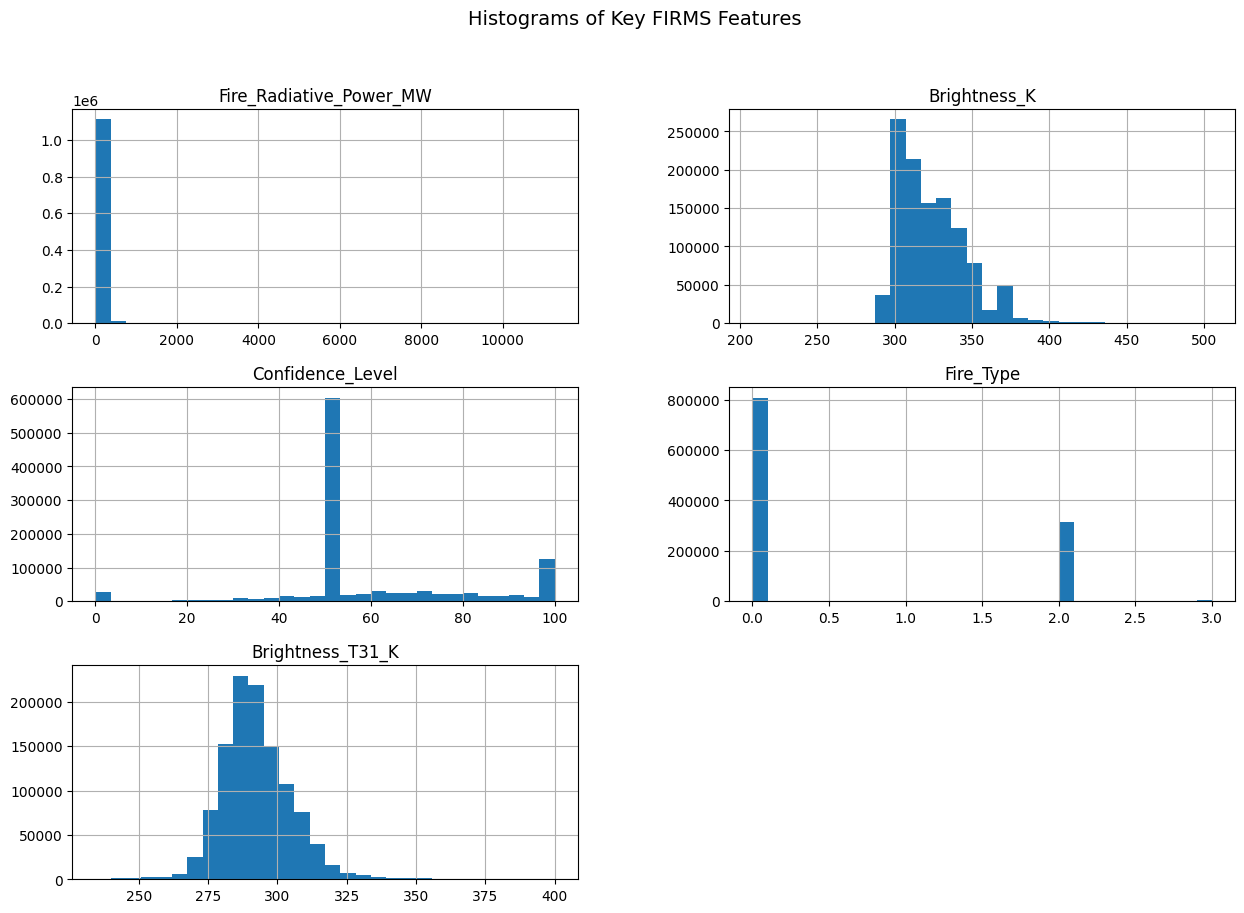

C:\Users\catar\AppData\Local\Temp\ipykernel_1284\3376468453.py:31: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



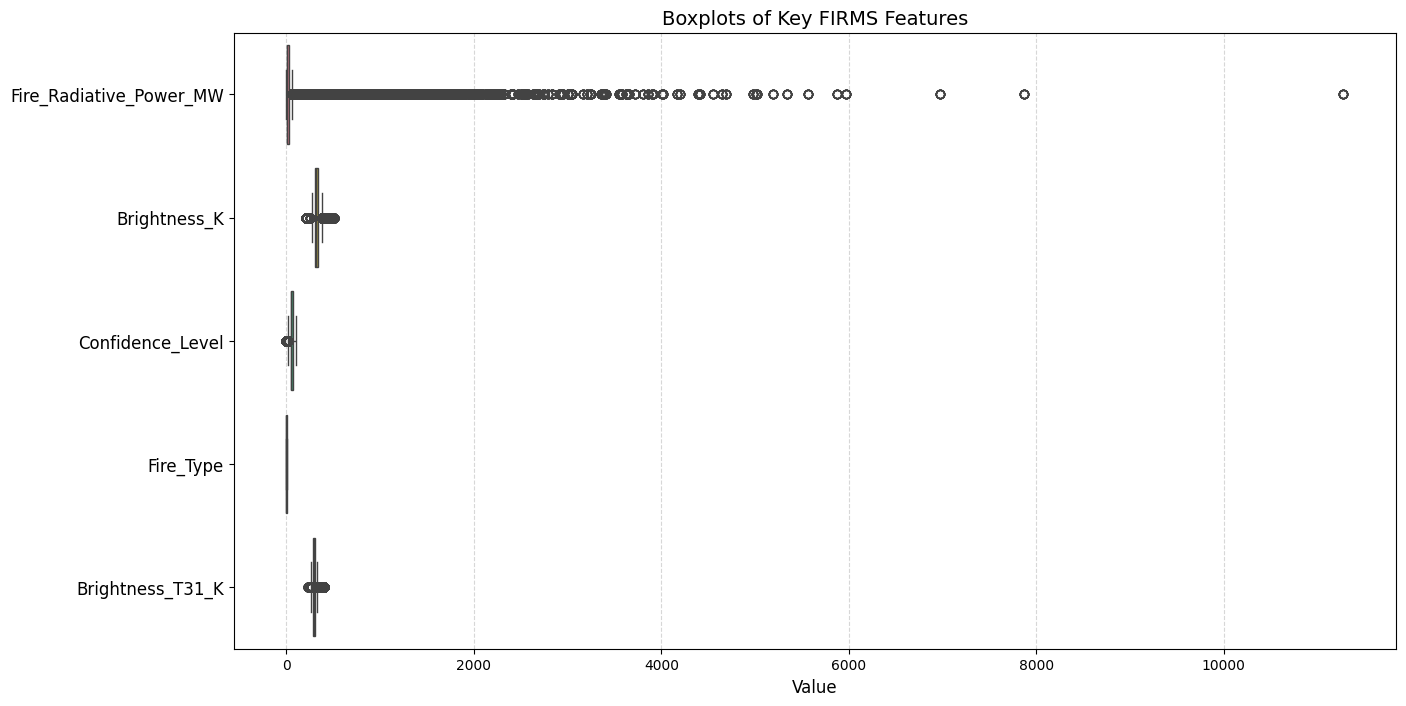

In [52]:
# Select a subset of key numerical features for visualization
fire_features = [
    "Fire_Radiative_Power_MW",
    "Brightness_K",
    "Confidence_Level",
    "Fire_Type",
    "Brightness_T31_K"]

# Convert to Pandas
df_pandas = FIRMS_dataset_w_country[fire_features].compute()

# Create histograms to visualize distributions
df_pandas.hist(figsize=(15, 10), bins=30)
plt.suptitle("Histograms of Key FIRMS Features", fontsize=14)
plt.show()

# Create boxplots to detect outliers

# Define colors for each feature
colors = sns.color_palette("husl", len(fire_features))

# Create a single figure with subplots
fig, ax = plt.subplots(figsize=(15, 8))

# Create a colorful, horizontal boxplot
sns.boxplot(data=df_pandas, orient="h", palette=colors, ax=ax)

# Labels and formatting
ax.set_title("Boxplots of Key FIRMS Features", fontsize=14)
ax.set_xlabel("Value", fontsize=12)
ax.set_yticklabels(fire_features, fontsize=12)
ax.grid(axis="x", linestyle="--", alpha=0.5)

plt.show()

#### Copernicus (Climate) Data Distribution

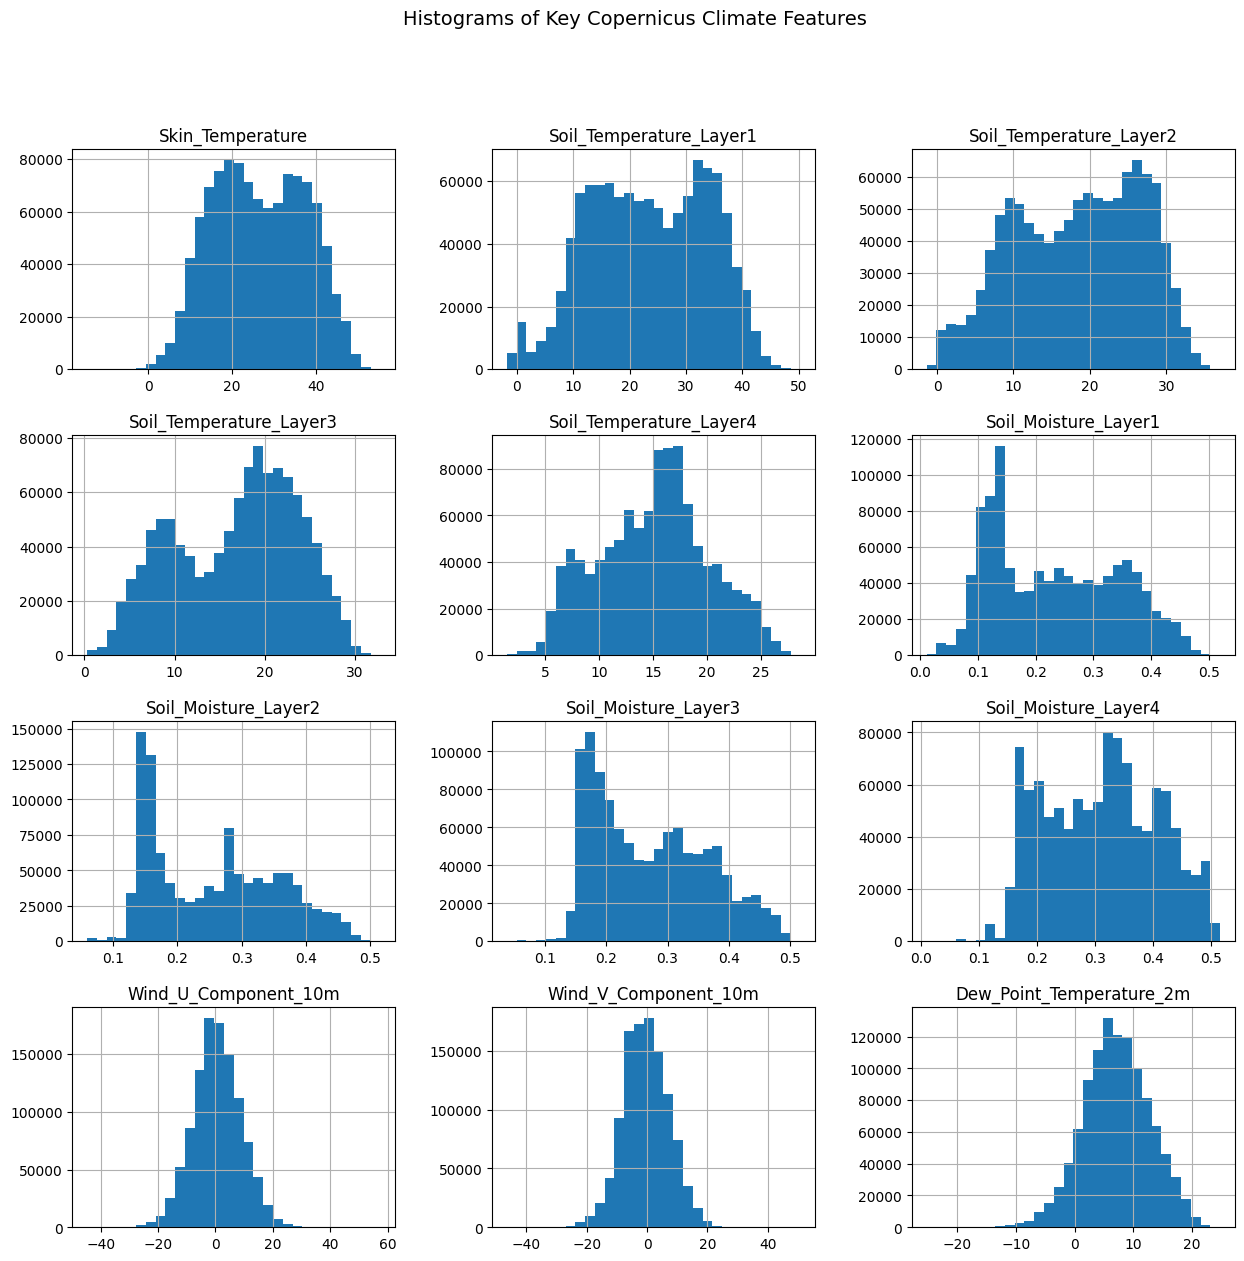

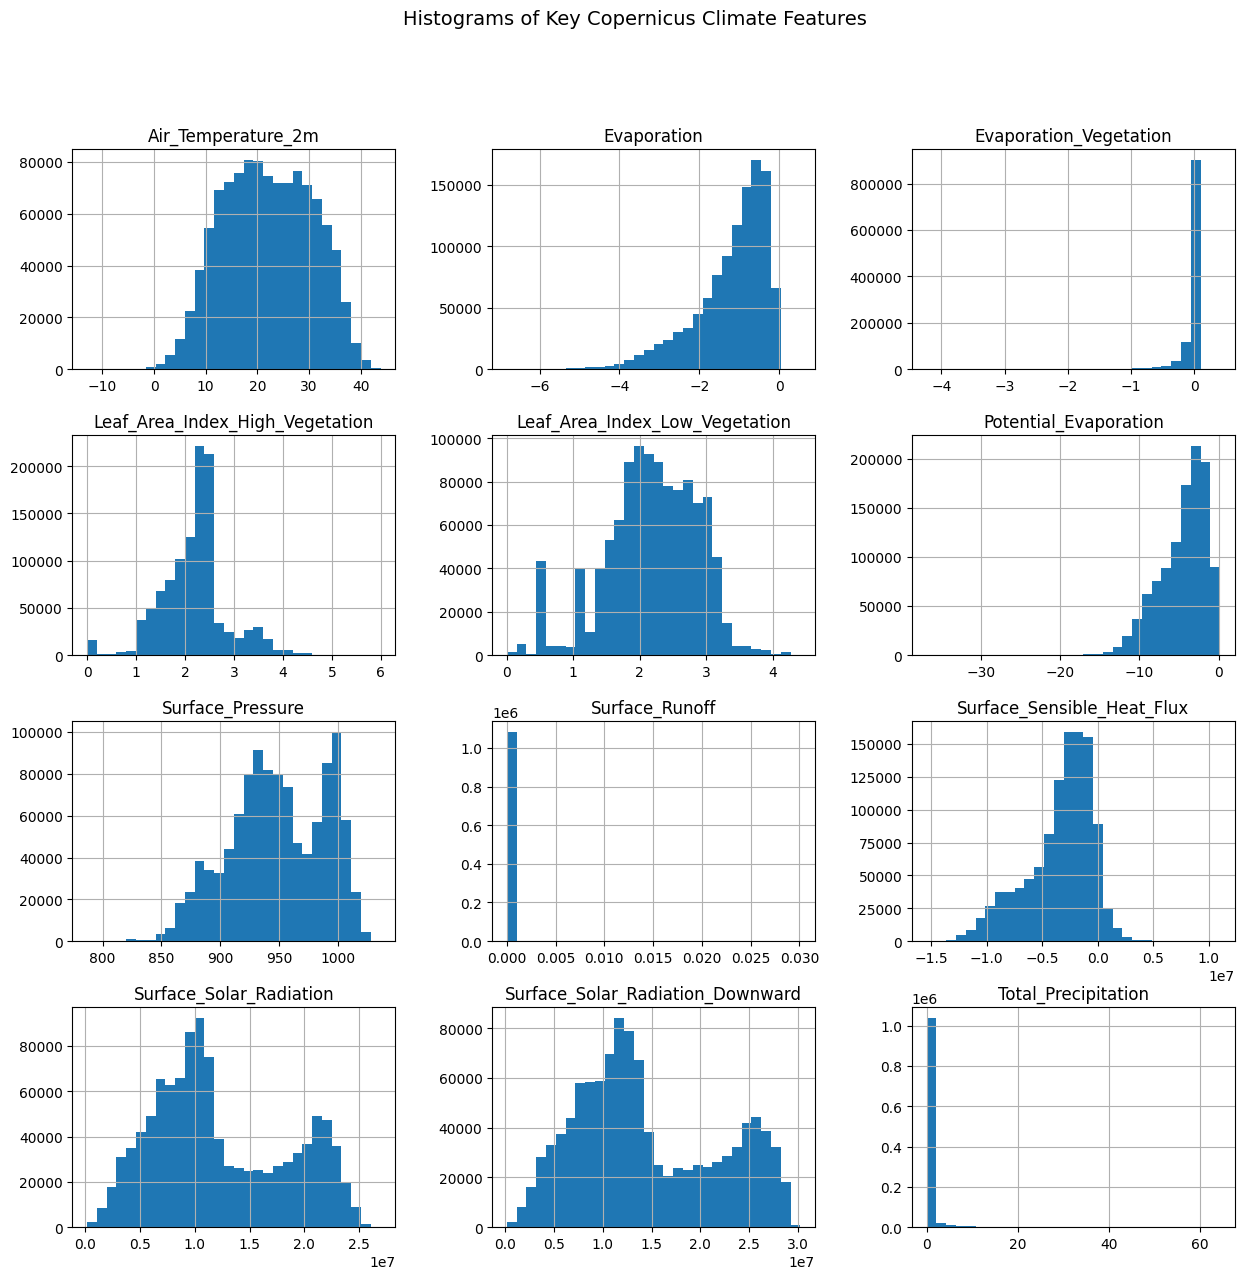

In [53]:
# Select a subset of key numerical features for visualization
weather_features1 = [
    "Skin_Temperature",
    "Soil_Temperature_Layer1",
    "Soil_Temperature_Layer2",
    "Soil_Temperature_Layer3",
    "Soil_Temperature_Layer4",
    "Soil_Moisture_Layer1",
    "Soil_Moisture_Layer2",
    "Soil_Moisture_Layer3",
    "Soil_Moisture_Layer4",
    "Wind_U_Component_10m",
    "Wind_V_Component_10m",
    "Dew_Point_Temperature_2m"
    ]

# Select a subset of key numerical features for visualization
weather_features2 = [
    "Air_Temperature_2m",
    "Evaporation",
    "Evaporation_Vegetation",
    "Leaf_Area_Index_High_Vegetation",
    "Leaf_Area_Index_Low_Vegetation",
    "Potential_Evaporation",
    "Surface_Pressure",
    "Surface_Runoff",
    "Surface_Sensible_Heat_Flux",
    "Surface_Solar_Radiation",
    "Surface_Solar_Radiation_Downward",
    "Total_Precipitation"]


# Convert to Pandas
df_pandas1 = dataset_with_all_variables[weather_features1].compute()
df_pandas2 = dataset_with_all_variables[weather_features2].compute()

# Create histograms to visualize distributions
df_pandas1.hist(figsize=(15, 14), bins=30)
plt.suptitle("Histograms of Key Copernicus Climate Features", fontsize=14)
plt.show()

df_pandas2.hist(figsize=(15, 14), bins=30)
plt.suptitle("Histograms of Key Copernicus Climate Features", fontsize=14)
plt.show()


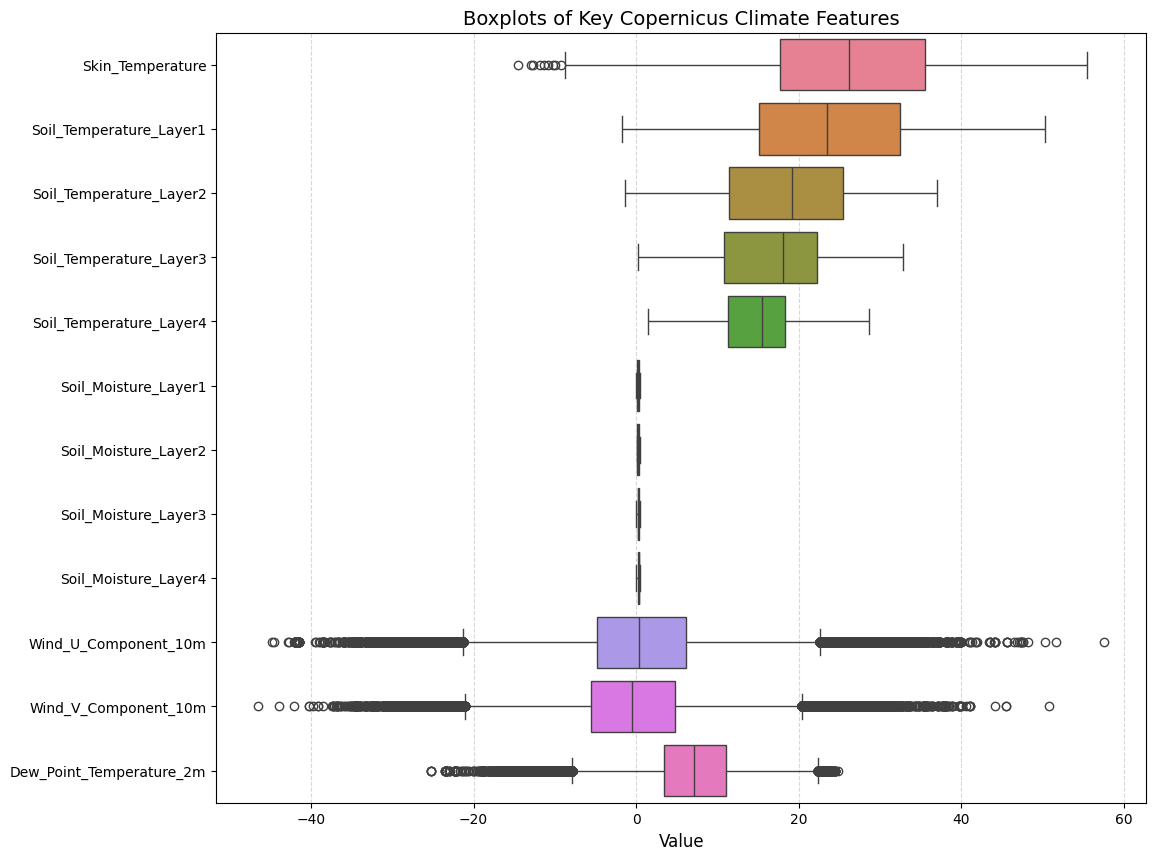

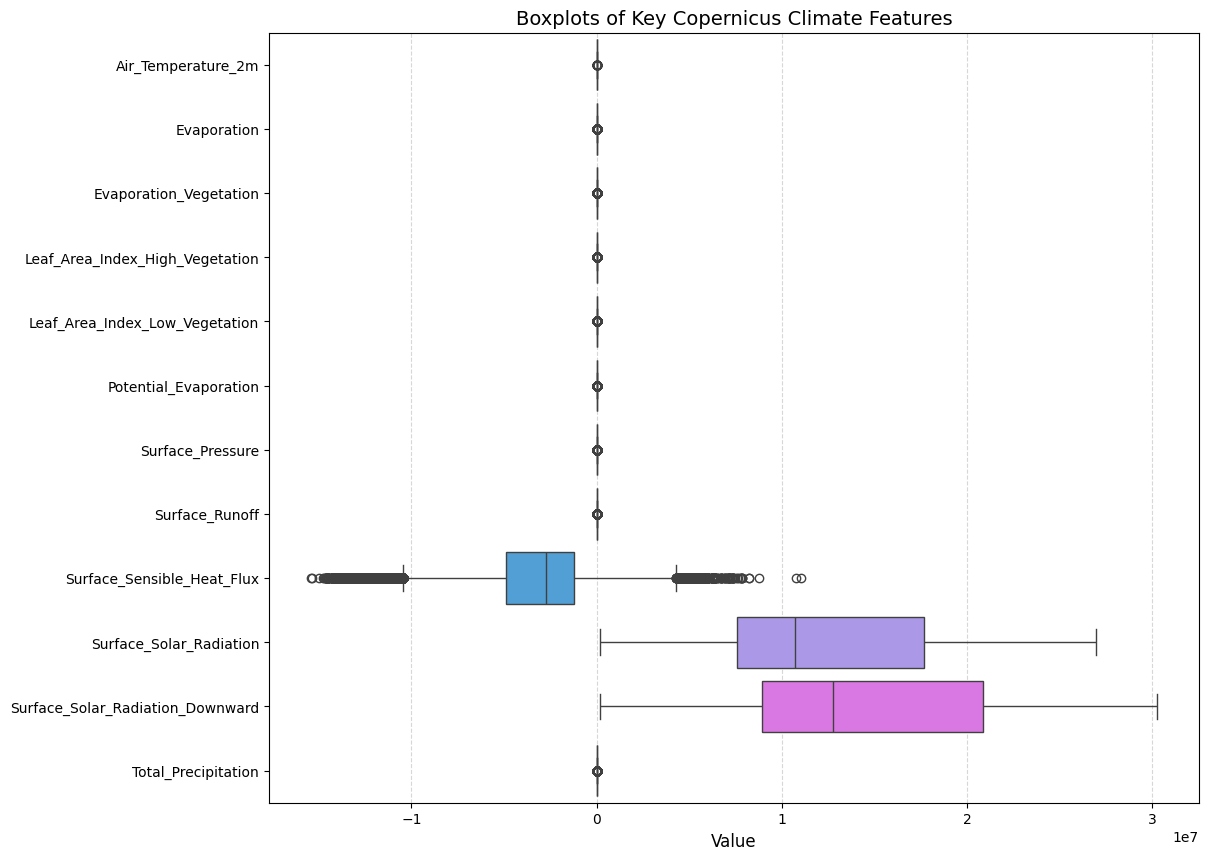

In [51]:
# Create boxplots to detect outliers

# Define colors for each feature
colors = sns.color_palette("husl", len(weather_features1))

# Create a single figure with subplots
fig, ax = plt.subplots(figsize=(12, 10))

# Create a colorful, horizontal boxplot
sns.boxplot(data=df_pandas1, orient="h", palette=colors, ax=ax)

# labels and formatting
ax.set_title("Boxplots of Key Copernicus Climate Features", fontsize=14)
ax.set_xlabel("Value", fontsize=12)
#ax.set_yticklabels(fire_features, fontsize=12)
ax.grid(axis="x", linestyle="--", alpha=0.5)

plt.show()

colors = sns.color_palette("husl", len(weather_features2))

# Create a single figure with subplots
fig, ax = plt.subplots(figsize=(12, 10))

# Create a colorful, horizontal boxplot
sns.boxplot(data=df_pandas2, orient="h", palette=colors, ax=ax)

# labels and formatting
ax.set_title("Boxplots of Key Copernicus Climate Features", fontsize=14)
ax.set_xlabel("Value", fontsize=12)
#ax.set_yticklabels(fire_features, fontsize=12)
ax.grid(axis="x", linestyle="--", alpha=0.5)

plt.show()

### FIRMS Specific Exploratory Analysis

#### Iberian FIRMS Data Analysis (with country breakdown where relevant)

In [27]:
FIRMS_dataset_w_country.head()

,Latitude,Longitude,Date,Time,Scan_Width_km,Fire_Radiative_Power_MW,Brightness_K,Confidence_Level,Track_Width_km,Fire_Type,Satellite,Day_Night,Brightness_T31_K,Dataset_Version,Instrument,Country
0,43.5249,-5.7303,2000-11-01,1131,1.0,7.8,301.1,45.0,1.0,2,Terra,D,269.8,6.03,MODIS,Spain
1,41.5184,-2.0833,2000-11-01,1132,1.1,15.8,312.4,55.0,1.1,0,Terra,D,280.1,6.03,MODIS,Spain
2,41.3399,-2.6720,2000-11-01,1132,1.1,12.6,309.7,0.0,1.0,0,Terra,D,274.0,6.03,MODIS,Spain
3,40.2732,-3.1756,2000-11-01,1132,1.1,19.9,319.2,79.0,1.0,0,Terra,D,288.3,6.03,MODIS,Spain
5,39.2529,-4.3232,2000-11-01,1132,1.0,3.8,302.9,54.0,1.0,0,Terra,D,290.1,6.03,MODIS,Spain


#### Iberian FIRMS Fire Count over the Years (Heatmap included)

This graph demonstrates the total number of fires in the dataset over the entire time period (all Fire Types, all Confidence Levels)

2025-02-09 15:58:01,535 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 476b3e32ec6a054eb8b3f79c7c156ab7 initialized by task ('shuffle-transfer-476b3e32ec6a054eb8b3f79c7c156ab7', 2) executed on worker tcp://127.0.0.1:50981
2025-02-09 15:58:05,624 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 476b3e32ec6a054eb8b3f79c7c156ab7 deactivated due to stimulus 'task-finished-1739116685.6225765'
2025-02-09 15:58:11,323 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f6f43782177b9fb07be998ffec2a0d3f initialized by task ('shuffle-transfer-f6f43782177b9fb07be998ffec2a0d3f', 2) executed on worker tcp://127.0.0.1:50981
2025-02-09 15:58:12,182 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f6f43782177b9fb07be998ffec2a0d3f deactivated due to stimulus 'task-finished-1739116692.17998'
2025-02-09 15:58:16,293 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cbfc4177f4b89aea3dabee68bb2ae7fc initialized by task ('shuffle-transfer-cbfc4177f4b89aea

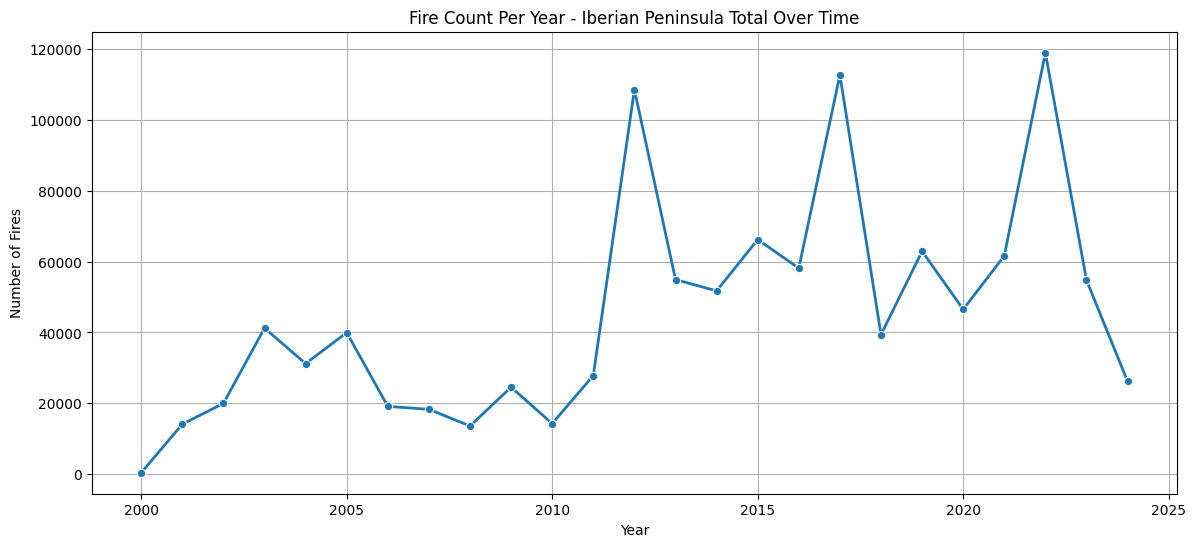

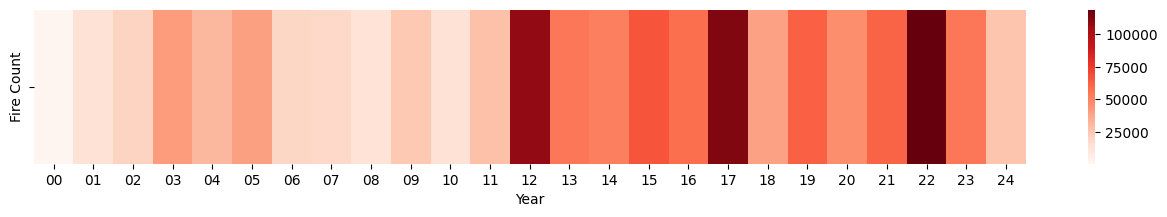

In [28]:
# Ensure Date column is in datetime format (Dask-compatible)
FIRMS_dataset_w_country["Date"] = dd.to_datetime(FIRMS_dataset_w_country["Date"], errors="coerce")

# Extract year
FIRMS_dataset_w_country["year"] = FIRMS_dataset_w_country["Date"].dt.year

# Compute fire counts per year
fires_per_year = FIRMS_dataset_w_country["year"].value_counts().compute().sort_index()
fires_per_year = fires_per_year.to_frame(name="fire_count")  # Convert to Pandas DataFrame

# Plot Fire Trends Over Years
plt.figure(figsize=(14, 6))
sns.lineplot(x=fires_per_year.index, y=fires_per_year["fire_count"], marker="o", linewidth=2)
plt.xlabel("Year")
plt.ylabel("Number of Fires")
plt.title("Fire Count Per Year - Iberian Peninsula Total Over Time")
plt.grid(True)

# Heatmap of Fire Count Per Year
years = fires_per_year.index.astype(str)  # Convert years to string for better heatmap labeling
fires = fires_per_year["fire_count"].values.reshape(1, -1)

# Modify x-axis labels to show only last 2 digits of year
years = [str(year)[-2:] for year in fires_per_year.index]  # Convert to last 2 digits

plt.figure(figsize=(16, 2))  # Wider figure for readability
sns.heatmap(fires, fmt="d", cmap="Reds", xticklabels=years, yticklabels=["Fire Count"], cbar=True)
plt.xlabel("Year")

plt.show()



#### Country Specific FIRMS Fire Count over the Years (Heatmap included) 

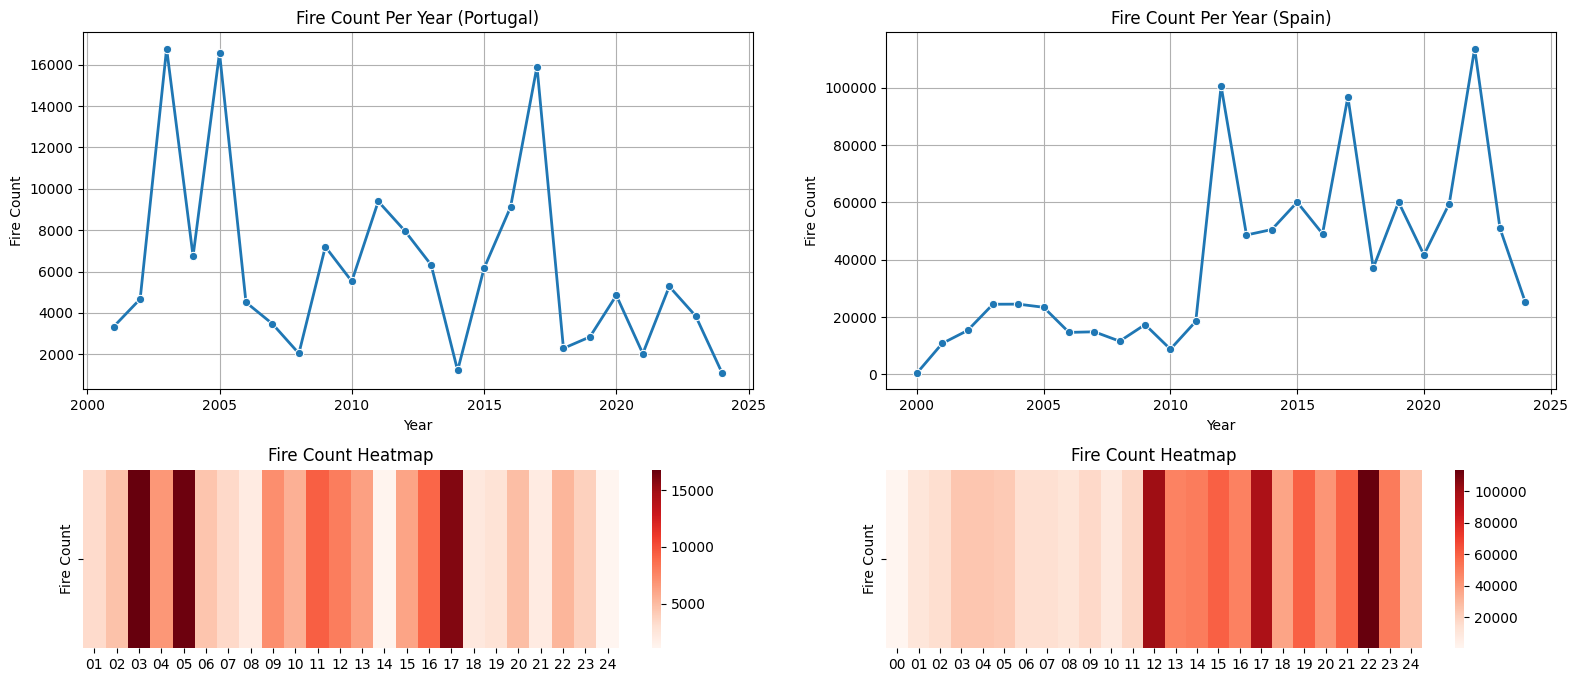

In [29]:
# Compute fire counts per year

Portugal_fire_count = FIRMS_dataset_w_country[FIRMS_dataset_w_country['Country'] == 'Portugal']
Portugal_fire_count = Portugal_fire_count["year"].value_counts().compute().sort_index()
Portugal_fire_count = Portugal_fire_count.to_frame(name="Portugal_fire_count")  # Convert to Pandas DataFrame

Spain_fire_count = FIRMS_dataset_w_country[FIRMS_dataset_w_country['Country'] == 'Spain']
Spain_fire_count = Spain_fire_count["year"].value_counts().compute().sort_index()
Spain_fire_count = Spain_fire_count.to_frame(name="Spain_fire_count")  # Convert to Pandas DataFrame

# Create a 2x2 grid layout
fig, axes = plt.subplots(2, 2, figsize=(19, 8), gridspec_kw={'height_ratios': [2, 1]})  # 2 rows, 2 columns

# Adjust layout spacing for clarity
plt.subplots_adjust(hspace=0.3, wspace=0.2)  

sns.lineplot(x=Portugal_fire_count.index, y=Portugal_fire_count["Portugal_fire_count"], marker="o", linewidth=2, ax=axes[0, 0])
axes[0, 0].set_title("Fire Count Per Year (Portugal)")
axes[0, 0].set_xlabel("Year")
axes[0, 0].set_ylabel("Fire Count")
axes[0, 0].grid(True)

sns.lineplot(x=Spain_fire_count.index, y=Spain_fire_count["Spain_fire_count"], marker="o", linewidth=2, ax=axes[0, 1])
axes[0, 1].set_title("Fire Count Per Year (Spain)")
axes[0, 1].set_xlabel("Year")
axes[0, 1].set_ylabel("Fire Count")
axes[0, 1].grid(True)


years = [str(year)[-2:] for year in Portugal_fire_count.index]  # Last 2 digits
fires = Portugal_fire_count["Portugal_fire_count"].values.reshape(1, -1)
sns.heatmap(fires, fmt="d", cmap="Reds", xticklabels=years, yticklabels=["Fire Count"], cbar=True, ax=axes[1, 0])
axes[1, 0].set_title("Fire Count Heatmap")

years = [str(year)[-2:] for year in Spain_fire_count.index]  # Last 2 digits
fires = Spain_fire_count["Spain_fire_count"].values.reshape(1, -1)
sns.heatmap(fires, fmt="d", cmap="Reds", xticklabels=years, yticklabels=["Fire Count"], cbar=True, ax=axes[1, 1])
axes[1, 1].set_title("Fire Count Heatmap")


# Show the grid of graphs
plt.show()



#### Fire Density per Country Area

The below chart demonstrates the different fire densities observed over each country (All Fire Types, All Confidence Levels). Country areas were sourced from the internet and made sure to include the island territories.

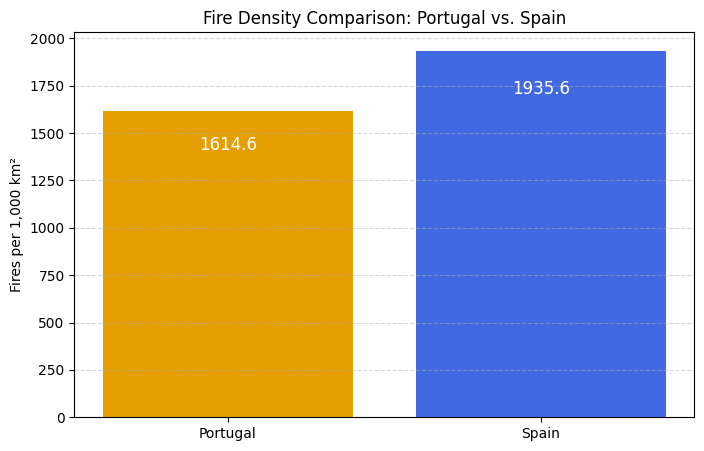

In [30]:
fire_counts = FIRMS_dataset_w_country.groupby("Country")["Confidence_Level"].count().compute()

# Define land area (km²) for Portugal & Spain
land_area = {"Portugal": 92391, "Spain": 505370}

# Compute fires per 1,000 km²
fires_per_1000_km2 = {country: fire_counts.get(country, 0) / (land_area[country] / 1000) for country in land_area.keys()}

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(fires_per_1000_km2.keys(), fires_per_1000_km2.values(), color=["#E69F00", "royalblue"])
plt.ylabel("Fires per 1,000 km²")
plt.title("Fire Density Comparison: Portugal vs. Spain")
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Show values inside bars with better spacing
for i, (country, value) in enumerate(fires_per_1000_km2.items()):
    plt.text(i, value * 0.92,  # Move text inside the bar (15% below the top)
             f"{value:.1f}", 
             ha="center", 
             fontsize=12, 
             va="top",  # Align text downwards inside the bar
             color="white")  # Keep contrast for visibility

plt.show()

#### Average Fire Radiative Power and Brightness Temperature per Country

0.0
11275.8


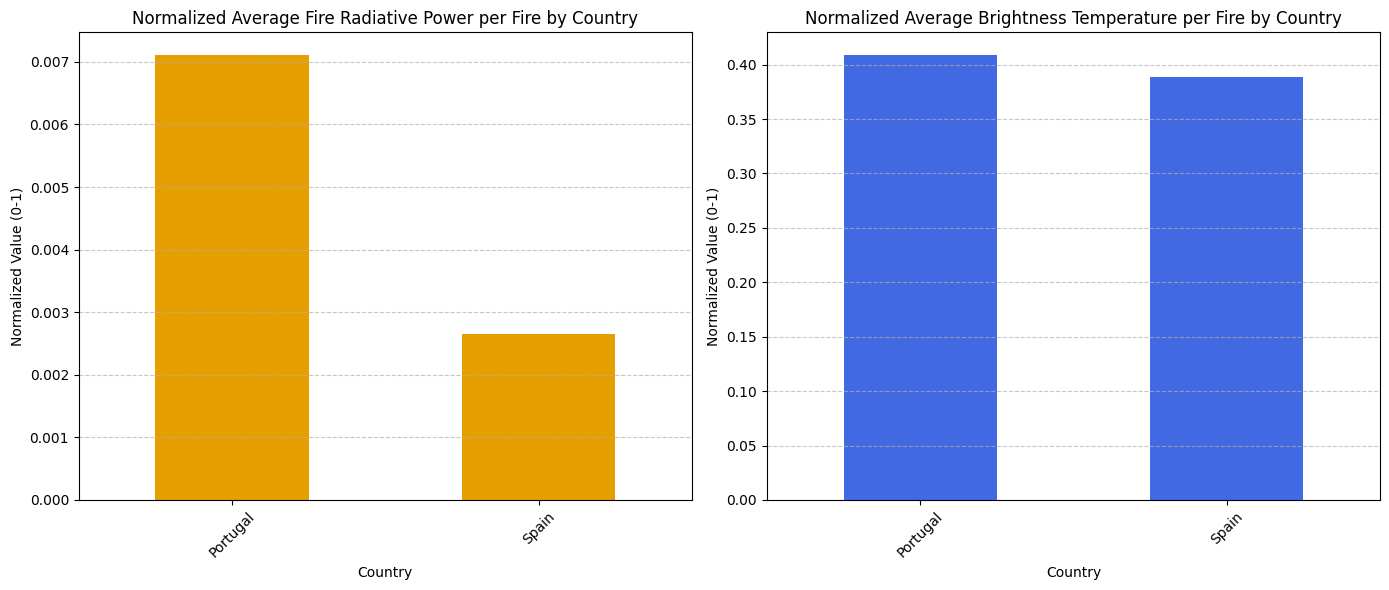

In [31]:
# Convert Dask DataFrame to Pandas (if necessary)
df_fire_for_intensity = FIRMS_dataset_w_country[["Fire_Radiative_Power_MW", "Brightness_K", "Country"]].compute()

# Print Min/Max for debugging
print(df_fire_for_intensity["Fire_Radiative_Power_MW"].min())
print(df_fire_for_intensity["Fire_Radiative_Power_MW"].max())

# Normalize Fire Radiative Power separately
scaler_FRP = MinMaxScaler()
df_fire_for_intensity["Fire_Radiative_Power_MW"] = scaler_FRP.fit_transform(df_fire_for_intensity[["Fire_Radiative_Power_MW"]].values)

# Normalize Brightness_K separately
scaler_Brightness = MinMaxScaler()
df_fire_for_intensity["Brightness_K"] = scaler_Brightness.fit_transform(df_fire_for_intensity[["Brightness_K"]].values)

# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1]})
plt.subplots_adjust(hspace=0.3, wspace=0.3)  # Adjust layout spacing

# Compute the average of the normalized values per country
normalized_avg_by_country = df_fire_for_intensity.groupby("Country")[["Fire_Radiative_Power_MW", "Brightness_K"]].mean()

# Separate metrics for individual plotting
normalized_avg_Radiative_Power = normalized_avg_by_country["Fire_Radiative_Power_MW"]
normalized_avg_Brightness = normalized_avg_by_country["Brightness_K"]

# Plot Fire Radiative Power (First subplot)
normalized_avg_Radiative_Power.plot(kind="bar", ax=axes[0], color="#E69F00")
axes[0].set_title("Normalized Average Fire Radiative Power per Fire by Country")
axes[0].set_xlabel("Country")
axes[0].set_ylabel("Normalized Value (0-1)")
axes[0].tick_params(axis="x", rotation=45)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Plot Brightness Temperature (Second subplot)
normalized_avg_Brightness.plot(kind="bar", ax=axes[1], color="royalblue")
axes[1].set_title("Normalized Average Brightness Temperature per Fire by Country")
axes[1].set_xlabel("Country")
axes[1].set_ylabel("Normalized Value (0-1)")
axes[1].tick_params(axis="x", rotation=45)
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


#### Confidence Levels Distribution

The below graph shows the distribution of confidence levels in the dataset, so we can understand the reliability of each record as per FIRMS standards.

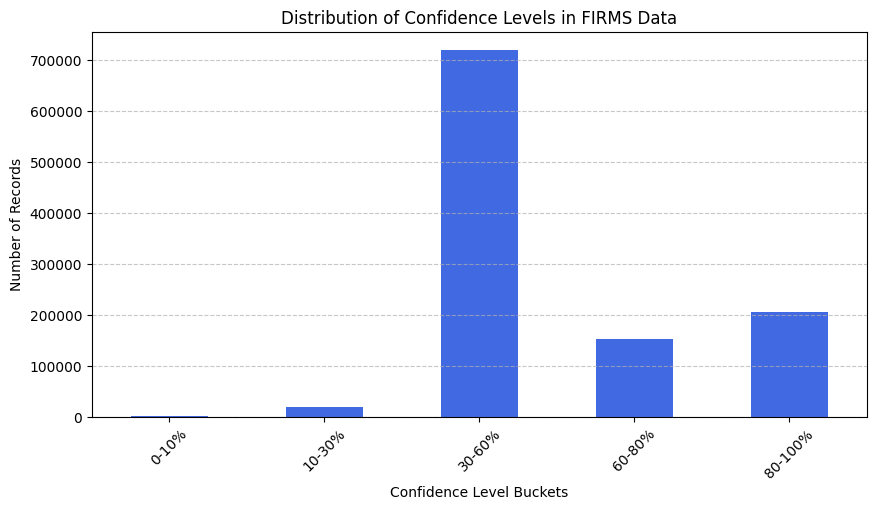

In [32]:
# Compute value counts before plotting (convert to Pandas)
confidence_levels = FIRMS_dataset_w_country['Confidence_Level'].compute()

# Define bins for confidence levels
bins = [0, 10, 30, 60, 80, 100]  # Adjust bucket ranges as needed
labels = ["0-10%", "10-30%", "30-60%", "60-80%", "80-100%"]

# Create binned categories
confidence_levels_binned = pd.cut(confidence_levels, bins=bins, labels=labels, right=True)

# Compute the count per bin
confidence_binned_counts = confidence_levels_binned.value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(10, 5))
confidence_binned_counts.plot(kind='bar', color='royalblue')
plt.xlabel("Confidence Level Buckets")
plt.ylabel("Number of Records")
plt.title("Distribution of Confidence Levels in FIRMS Data")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


#### Iberian FIRMS Fire Types Distribution over Time

The below chart shows the proportion of fire types over time - Pie chart shows the overall proportion for the entire time period

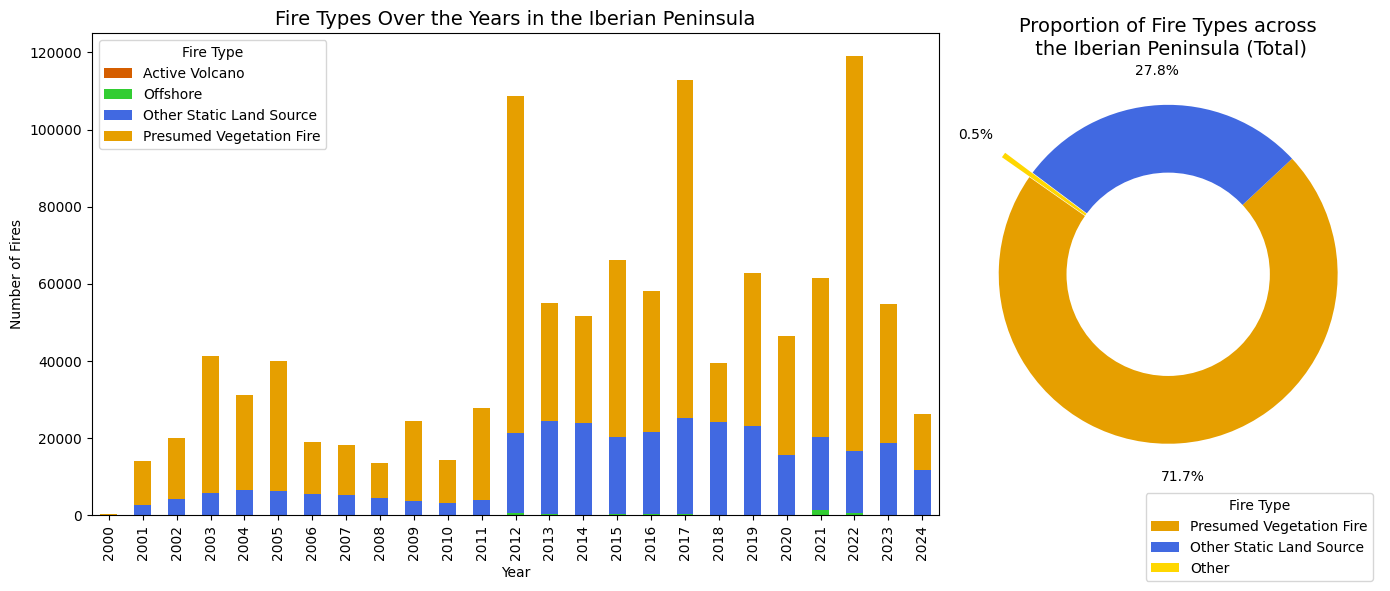

In [47]:
# Fire Type Mapping Dictionary
fire_type_dict = {
    0: "Presumed Vegetation Fire",
    1: "Active Volcano",
    2: "Other Static Land Source",
    3: "Offshore"
}

# Define consistent colors for both charts
color_mapping = {
    "Presumed Vegetation Fire": "#E69F00",  # Orange
    "Other Static Land Source": 'royalblue',#"#0072B2",  # Dark Blue
    "Active Volcano": "#D55E00",  # Red
    "Offshore": "#32CD32",  # Purple
    "Other": "#FFD700"  # Light Blue for grouped categories
}

# Fire Type Data for Pie Chart
fire_counts_per_type = FIRMS_dataset_w_country['Fire_Type'].value_counts().compute()

fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 1]})
plt.subplots_adjust(hspace=0.3, wspace=0.2)  

# Stacked Bar Chart Data Preparation
df_yearly_fire_type = FIRMS_dataset_w_country.groupby(['year', 'Fire_Type']).size().compute().reset_index(name='Count')

# Replace numeric Fire_Type with descriptions
df_yearly_fire_type['Fire_Type'] = df_yearly_fire_type['Fire_Type'].map(fire_type_dict)

# Pivot for stacked bar chart
df_pivot = df_yearly_fire_type.pivot(index="year", columns="Fire_Type", values="Count").fillna(0)

# Stacked Bar Chart (Left)
df_pivot.plot(kind="bar", stacked=True, ax=axes[0], color=[color_mapping[col] for col in df_pivot.columns])
axes[0].set_title("Fire Types Over the Years in the Iberian Peninsula", fontsize=14)
axes[0].set_ylabel("Number of Fires")
axes[0].set_xlabel("Year")
axes[0].legend(title="Fire Type", loc="upper left")

# Pie Chart (Right)
# Define a threshold (e.g., categories with < 5% will be grouped)
threshold = 0.05 * fire_counts_per_type.sum()

# Separate major and minor categories
major_fire_counts = fire_counts_per_type[fire_counts_per_type >= threshold]
minor_fire_counts = fire_counts_per_type[fire_counts_per_type < threshold]

# Sum small categories into "Other"
if not minor_fire_counts.empty:
    major_fire_counts["Other"] = minor_fire_counts.sum()

# Map only the major category labels
fire_labels = [fire_type_dict[i] if i in fire_type_dict else "Other" for i in major_fire_counts.index]

# Use consistent colors for Pie Chart
pie_colors = [color_mapping[label] for label in fire_labels]

# Plot Pie Chart
wedges, texts, autotexts = axes[1].pie(
    major_fire_counts,
    autopct='%1.1f%%',
    startangle=145,
    colors=pie_colors,
    explode=[0, 0, 0.2],#explode_values,
    pctdistance=1.2
)

# Convert to Donut Chart by Adding a White Circle in the Center
centre_circle = plt.Circle((0, 0), 0.60, fc='white')  # Creates the hole
axes[1].add_artist(centre_circle)

# Add Legend for Pie Chart
axes[1].legend(wedges, fire_labels, title="Fire Type", bbox_to_anchor=(1.0, 0.0))

# Set Pie Chart Title
axes[1].set_title("Proportion of Fire Types across\n the Iberian Peninsula (Total)", fontsize=14)

# Adjust Layout
plt.tight_layout()
plt.show()


#### Portugal and Spain FIRMS Fire Types Distribution over Time

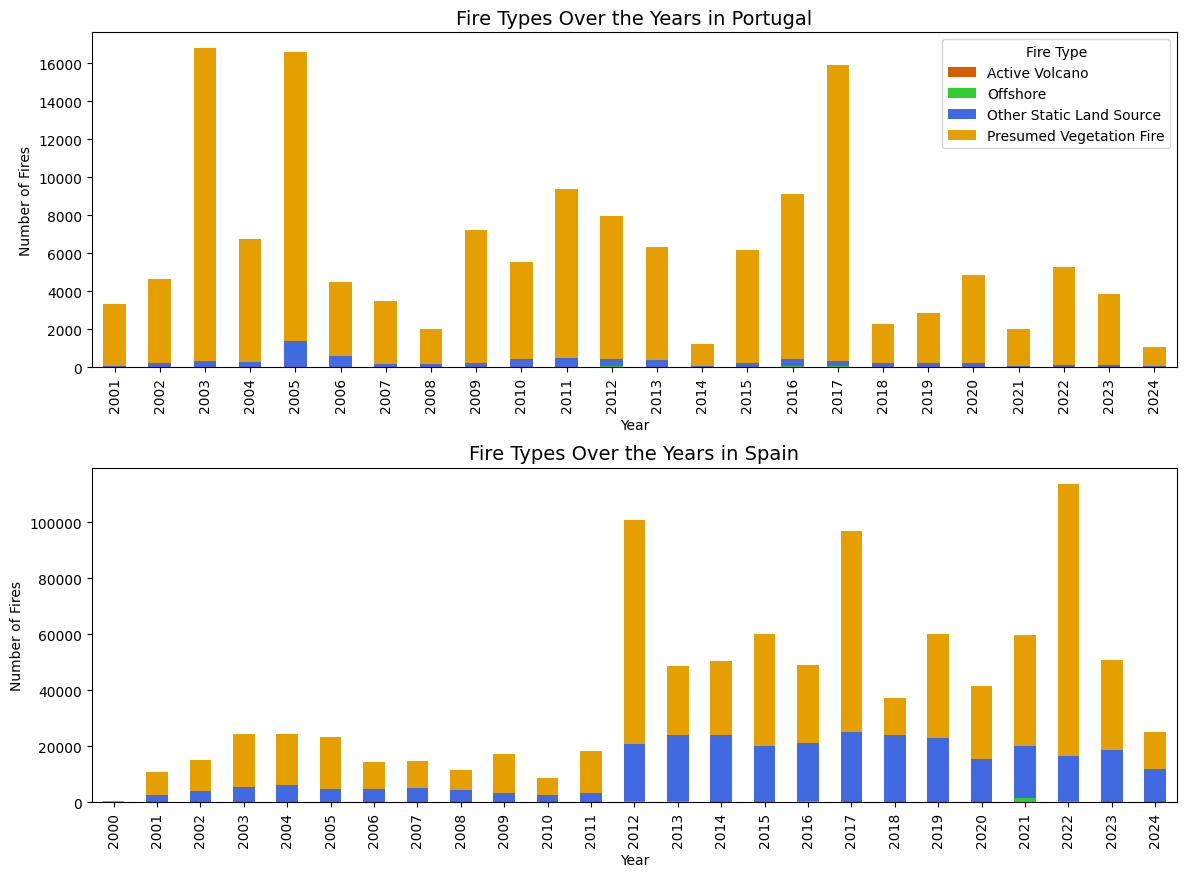

In [34]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
# Adjust layout spacing for clarity
plt.subplots_adjust(hspace=0.3, wspace=0.2)  

# Stacked Bar Chart Data Preparation
df_yearly_type_by_country = FIRMS_dataset_w_country.groupby(['Country', 'year', 'Fire_Type']).size().compute().reset_index(name='Count')

df_yearly_type_Portugal = df_yearly_type_by_country[df_yearly_type_by_country['Country'] == 'Portugal'].copy()
df_yearly_type_Spain = df_yearly_type_by_country[df_yearly_type_by_country['Country'] == 'Spain'].copy()

# Replace numeric Fire_Type with descriptions
df_yearly_type_Portugal['Fire_Type'] = df_yearly_type_Portugal['Fire_Type'].map(fire_type_dict)

# Pivot for stacked bar chart
df_pivot_portugal = df_yearly_type_Portugal.pivot(index="year", columns="Fire_Type", values="Count").fillna(0)

# Stacked Bar Chart (Top)
df_pivot_portugal.plot(kind="bar", stacked=True, ax=axes[0], color=[color_mapping[col] for col in df_pivot.columns])
axes[0].set_title("Fire Types Over the Years in Portugal", fontsize=14)
axes[0].set_ylabel("Number of Fires")
axes[0].set_xlabel("Year")
axes[0].legend(title="Fire Type", loc="upper right")

# Replace numeric Fire_Type with descriptions
df_yearly_type_Spain['Fire_Type'] = df_yearly_type_Spain['Fire_Type'].map(fire_type_dict)

# Pivot for stacked bar chart
df_pivot_spain = df_yearly_type_Spain.pivot(index="year", columns="Fire_Type", values="Count").fillna(0)

# Stacked Bar Chart (Bottom)
df_pivot_spain.plot(kind="bar", stacked=True, ax=axes[1], color=[color_mapping[col] for col in df_pivot.columns])
axes[1].set_title("Fire Types Over the Years in Spain", fontsize=14)
axes[1].set_ylabel("Number of Fires")
axes[1].set_xlabel("Year")
axes[1].legend().set_visible(False)

plt.show()






#### Correlation between Fire Radiative Power and Brightness Correlation 

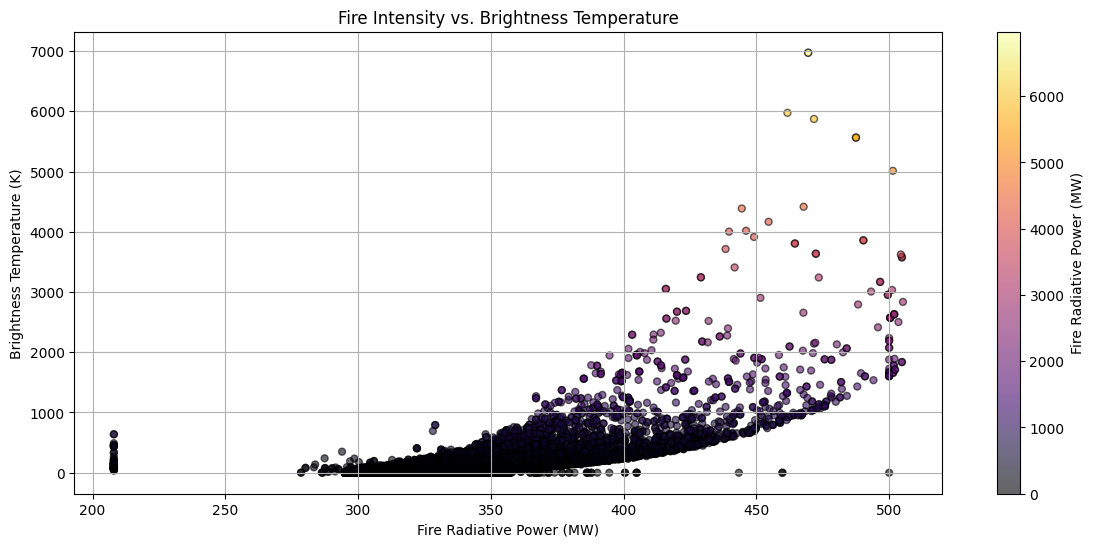

In [35]:
# Compute data for scatter plot
df_scatter = FIRMS_dataset_w_country[["Fire_Radiative_Power_MW", "Brightness_K"]].sample(frac=0.1).compute()

# Scatter Plot with Transparency and Color Gradient
plt.figure(figsize=(14, 6))
scatter = plt.scatter(df_scatter["Brightness_K"], df_scatter["Fire_Radiative_Power_MW"], 
                      c=df_scatter["Fire_Radiative_Power_MW"], cmap="inferno", alpha=0.6, edgecolors="black", s=25)

# Colorbar to indicate FRP intensity
plt.colorbar(scatter, label="Fire Radiative Power (MW)")

plt.xlabel("Fire Radiative Power (MW)")
plt.ylabel("Brightness Temperature (K)")
plt.title("Fire Intensity vs. Brightness Temperature")

plt.grid(True)
plt.show()



#### Top 30 Fire-Prone Areas Per Country (Vegetation Fires & Confidence ≥ 30)

In [36]:
# Ensure FIRMS_dataset_w_country is a Pandas DataFrame
if not isinstance(FIRMS_dataset_w_country, pd.DataFrame):
    FIRMS_dataset_w_country_pd = FIRMS_dataset_w_country.compute()
else:
    FIRMS_dataset_w_country_pd = FIRMS_dataset_w_country.copy()

# Define range for dot sizes
MIN_DOT_SIZE = 5 # Smallest dot size
MAX_DOT_SIZE = 15  # Largest dot size

# Filter dataset for Confidence_Level >= 30 and Fire_Type == 0 (Vegetation Fires)
df_filtered = FIRMS_dataset_w_country_pd[
    (FIRMS_dataset_w_country_pd["Confidence_Level"] >= 30) & 
    (FIRMS_dataset_w_country_pd["Fire_Type"] == 0)
]

# Round Latitude and Longitude to 1 decimal places for broader grouping
df_filtered["Rounded_Latitude"] = df_filtered["Latitude"].round(1)
df_filtered["Rounded_Longitude"] = df_filtered["Longitude"].round(1)

# Aggregate fire count by rounded location and country
fire_counts_per_country = (
    df_filtered
    .groupby(["Country", "Rounded_Latitude", "Rounded_Longitude"])
    .size()
    .reset_index(name="Fire_Count")
)

# Get the top 10 locations per country with the highest number of fires
top_10_per_country = (
    fire_counts_per_country
    .groupby("Country")
    .apply(lambda x: x.nlargest(30, "Fire_Count"))
    .reset_index(drop=True)
)

# Normalize fire count to fit within the desired dot size range
min_fire_count = top_10_per_country["Fire_Count"].min()
max_fire_count = top_10_per_country["Fire_Count"].max()

top_10_per_country["Fire_Count_Scaled"] = top_10_per_country["Fire_Count"].apply(
    lambda x: MIN_DOT_SIZE + ((x - min_fire_count) / (max_fire_count - min_fire_count)) * (MAX_DOT_SIZE - MIN_DOT_SIZE)
)

# Assign a unique color to each country
color_map = {
    "Portugal": "blue",
    "Spain": "red"
}

# Create an interactive map with properly scaled markers
fig = go.Figure()

for country in top_10_per_country["Country"].unique():
    subset = top_10_per_country[top_10_per_country["Country"] == country]
    
    # Assign a color based on the country
    country_color = color_map.get(country, "gray")  # Use "gray" for unlisted countries

    fig.add_trace(go.Scattermapbox(
        lat=subset["Rounded_Latitude"],
        lon=subset["Rounded_Longitude"],
        mode="markers",
        marker=dict(
            size=subset["Fire_Count_Scaled"],  # Adjusted size for better visibility
            color=country_color,  # Assign different colors per country
            opacity=0.7
        ),
        text=subset["Fire_Count"],
        name=country
    ))

# Update layout for a well-balanced visualization
fig.update_layout(
    title="Top 30 Fire-Prone Areas Per Country (Vegetation Fires & Confidence ≥ 30)",
    autosize=True,
    width=1000,  # Increase width
    height=700,  # Increase height
    mapbox=dict(
        style="open-street-map",
        zoom=5,
        center=dict(lat=40, lon=-4)
    )
)

# Show the interactive map
fig.show()


C:\Users\catar\AppData\Local\Temp\ipykernel_1284\787694375.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Rounded_Latitude"] = df_filtered["Latitude"].round(1)
C:\Users\catar\AppData\Local\Temp\ipykernel_1284\787694375.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Rounded_Longitude"] = df_filtered["Longitude"].round(1)
C:\Users\catar\AppData\Local\Temp\ipykernel_1284\787694375.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

### Fire Incidence and Climate Variables Exploratory Analysis

#### Correlation between Climate Variables and Fire Intensity Variables

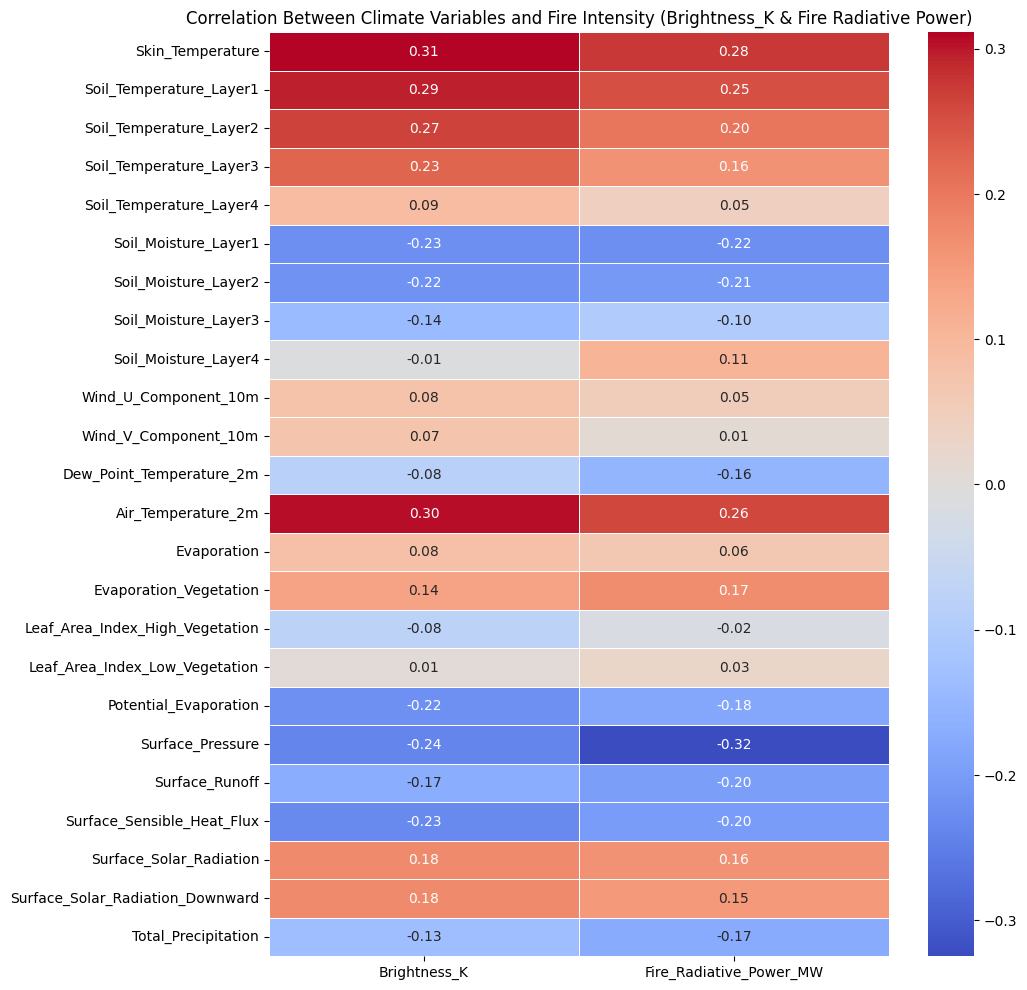

In [54]:
dataset_with_all_variables_df = dataset_with_all_variables.compute()

# Select only the relevant climate variables and fire intensity metrics
climate_variables = [
    'Skin_Temperature', 'Soil_Temperature_Layer1', 'Soil_Temperature_Layer2', 
    'Soil_Temperature_Layer3', 'Soil_Temperature_Layer4', 'Soil_Moisture_Layer1',
    'Soil_Moisture_Layer2', 'Soil_Moisture_Layer3', 'Soil_Moisture_Layer4',
    'Wind_U_Component_10m', 'Wind_V_Component_10m', 'Dew_Point_Temperature_2m',
    'Air_Temperature_2m', 'Evaporation', 'Evaporation_Vegetation', 
    'Leaf_Area_Index_High_Vegetation', 'Leaf_Area_Index_Low_Vegetation', 
    'Potential_Evaporation', 'Surface_Pressure', 'Surface_Runoff', 
    'Surface_Sensible_Heat_Flux', 'Surface_Solar_Radiation', 
    'Surface_Solar_Radiation_Downward', 'Total_Precipitation'
]

fire_variables = ['Brightness_K', 'Fire_Radiative_Power_MW']

numeric_dataset = dataset_with_all_variables_df.copy()

# Ensure only numeric data is selected
numeric_dataset = numeric_dataset[climate_variables + fire_variables].select_dtypes(include=["number"])

# Compute correlation matrix only between climate variables and fire intensity metrics
correlation_matrix = numeric_dataset.corr(method='spearman').loc[climate_variables, fire_variables]

plt.figure(figsize=(10, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Climate Variables and Fire Intensity (Brightness_K & Fire Radiative Power)")
plt.show()



#### Temporal Climate Patterns Leading to Fire Events

<Figure size 1200x600 with 0 Axes>

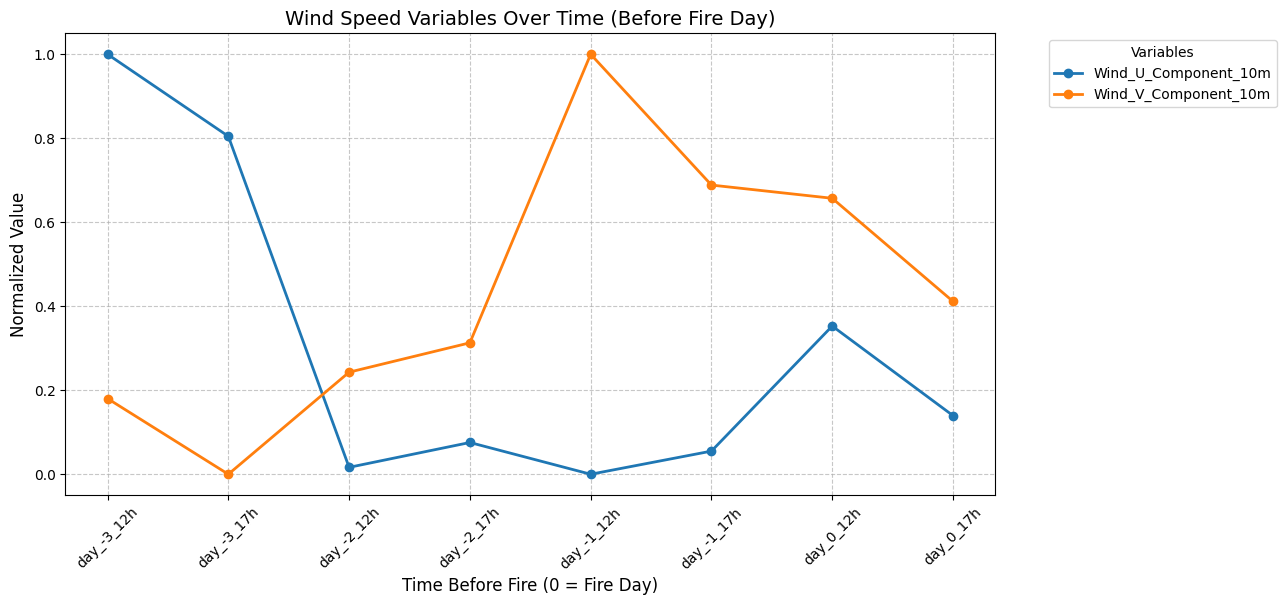

In [56]:
# Copy the dataset
climate_time_avg = dataset_with_all_variables_df.copy()

# Convert date columns
climate_time_avg['Climate_Date'] = pd.to_datetime(climate_time_avg['Climate_Date'], errors='coerce')
climate_time_avg['Date'] = pd.to_datetime(climate_time_avg['Date'], errors='coerce')

# Filtering criteria
climate_time_avg = climate_time_avg[climate_time_avg["Fire_Type"] == 0]
climate_time_avg = climate_time_avg[climate_time_avg["Confidence_Level"] >= 30]

# Ensure Climate_Time is treated as a number
climate_time_avg['Climate_Time'] = pd.to_numeric(climate_time_avg['Climate_Time'], errors='coerce')

# List of variables to track
variables_to_track = [
    'Skin_Temperature', 'Soil_Temperature_Layer1', 'Soil_Temperature_Layer2',
    'Soil_Temperature_Layer3', 'Soil_Temperature_Layer4', 'Soil_Moisture_Layer1',
    'Soil_Moisture_Layer2', 'Soil_Moisture_Layer3', 'Soil_Moisture_Layer4',
    'Wind_U_Component_10m', 'Wind_V_Component_10m', 'Dew_Point_Temperature_2m',
    'Air_Temperature_2m', 'Evaporation', 'Evaporation_Vegetation', 
    'Leaf_Area_Index_High_Vegetation', 'Leaf_Area_Index_Low_Vegetation',
    'Potential_Evaporation', 'Surface_Pressure', 'Surface_Runoff',
    'Surface_Sensible_Heat_Flux', 'Surface_Solar_Radiation',
    'Surface_Solar_Radiation_Downward', 'Total_Precipitation'
]

# Dictionary to store means per climate time period (12.0, 17.0)
mean_df_climate_time = {}

# Iterate over days
for day in range(0, 4):  # From 0 (Fire Day) to -3
    for climate_hour in [12.0, 17.0]:  # Select times: 12.0 and 17.0
        
        # Calculate the target date
        target_date = climate_time_avg['Date'].max() - pd.Timedelta(days=day)

        # Filter dataset for this date and climate time
        dataset_filtered = climate_time_avg[
            (climate_time_avg['Climate_Date'] == target_date) & 
            (climate_time_avg['Climate_Time'] == climate_hour)
        ]

        # Compute mean for each column
        mean_values = dataset_filtered[variables_to_track].mean()

        # Store mean values indexed by day and climate hour
        mean_df_climate_time[f"day_{-day}_{int(climate_hour)}h"] = mean_values

# Convert to DataFrame
df_mean_climate_time = pd.DataFrame(mean_df_climate_time)

# Transpose for proper column structure
df_mean_climate_time = df_mean_climate_time.T

# Reset index before normalization
df_mean_climate_time = df_mean_climate_time.reset_index()

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply MinMaxScaler column-wise (axis=0)
df_mean_normalized_climate_time = pd.DataFrame(
    scaler.fit_transform(df_mean_climate_time.iloc[:, 1:]),  # Exclude index column
    columns=df_mean_climate_time.columns[1:],  # Preserve column names
    index=df_mean_climate_time["index"]  # Restore index names
)

df_mean_normalized_climate_time = df_mean_normalized_climate_time.T

# Function to extract sorting key from column names
def extract_sort_key(column_name):
    parts = column_name.split("_")
    return (int(parts[1]), int(parts[2][:-1]))  # Extract day (integer) and hour (integer)

# Sort the columns in the correct order
sorted_columns = sorted(df_mean_normalized_climate_time.columns, key=extract_sort_key)

# Apply the sorted order
df_mean_normalized_climate_time_reversed = df_mean_normalized_climate_time[sorted_columns]

# Grouping variables for plotting
variable_groups = {
    "Wind Speed Variables": ["Wind_U_Component_10m", "Wind_V_Component_10m"],
    "Heat Variables - Soil": [
        "Soil_Temperature_Layer1", "Soil_Temperature_Layer2",
        "Soil_Temperature_Layer3", "Soil_Temperature_Layer4"
    ],
    "Heat Variables - Air": [
        "Skin_Temperature", "Air_Temperature_2m"
    ],
    "Radiative & Flux Variables": [
        "Potential_Evaporation", "Surface_Solar_Radiation", "Surface_Solar_Radiation_Downward",
        "Surface_Sensible_Heat_Flux"
    ],
    "Moisture & Water Storage": [
        "Soil_Moisture_Layer1", "Soil_Moisture_Layer2", "Soil_Moisture_Layer3",
        "Soil_Moisture_Layer4", "Dew_Point_Temperature_2m"
    ],
    "Evaporation & Precipitation": [
        "Evaporation", "Total_Precipitation"
    ],
    "Atmospheric & Surface Pressure": [
        "Surface_Pressure", "Surface_Runoff"
    ],
    "Vegetation Variables": [
        "Evaporation_Vegetation"
    ]
}

# Function to plot each group
def plot_variable_group(df_mean_normalized_climate_time, group_name, variables):
    plt.figure(figsize=(12, 6))

    # Select relevant variables
    df_filtered = df_mean_normalized_climate_time.loc[df_mean_normalized_climate_time.index.intersection(variables)]

    # Transpose to align x-axis labels correctly
    df_filtered.T.plot(kind='line', marker='o', figsize=(12, 6), linewidth=2)

    # Formatting the plot
    plt.title(f'{group_name} Over Time (Before Fire Day)', fontsize=14)
    plt.xlabel('Time Before Fire (0 = Fire Day)', fontsize=12)
    plt.ylabel('Normalized Value', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title="Variables", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()


plot_variable_group(df_mean_normalized_climate_time_reversed, "Wind Speed Variables", ["Wind_U_Component_10m", "Wind_V_Component_10m"])


<Figure size 1200x600 with 0 Axes>

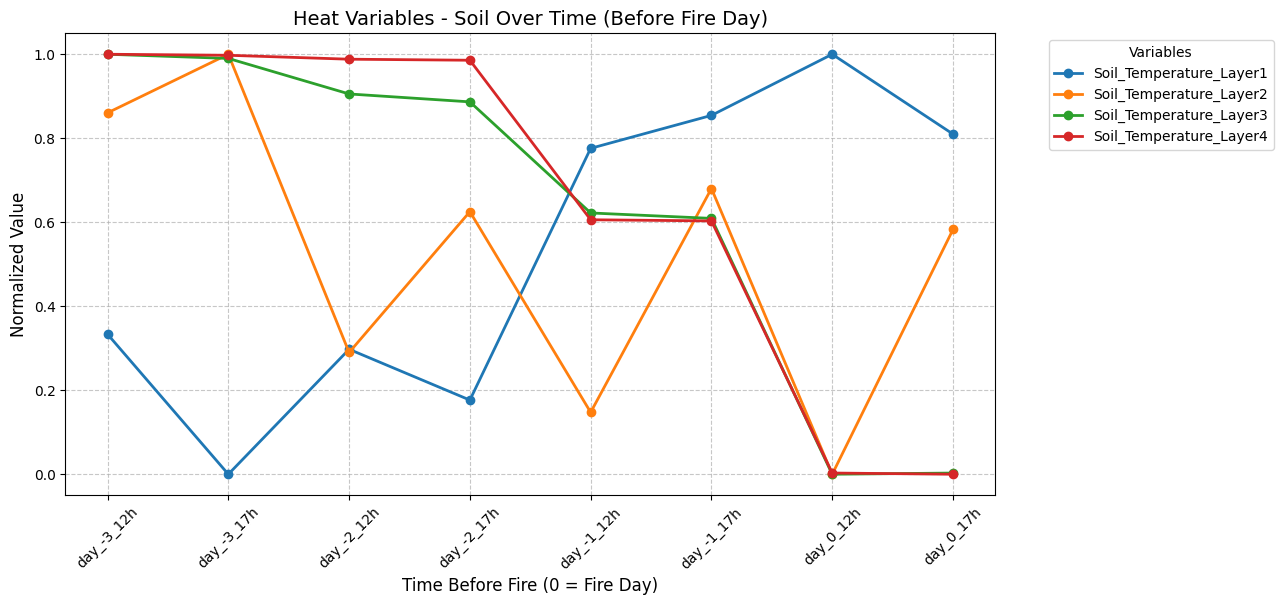

In [39]:
plot_variable_group(df_mean_normalized_climate_time_reversed, "Heat Variables - Soil", [
        "Soil_Temperature_Layer1", "Soil_Temperature_Layer2",
        "Soil_Temperature_Layer3", "Soil_Temperature_Layer4"
    ])


<Figure size 1200x600 with 0 Axes>

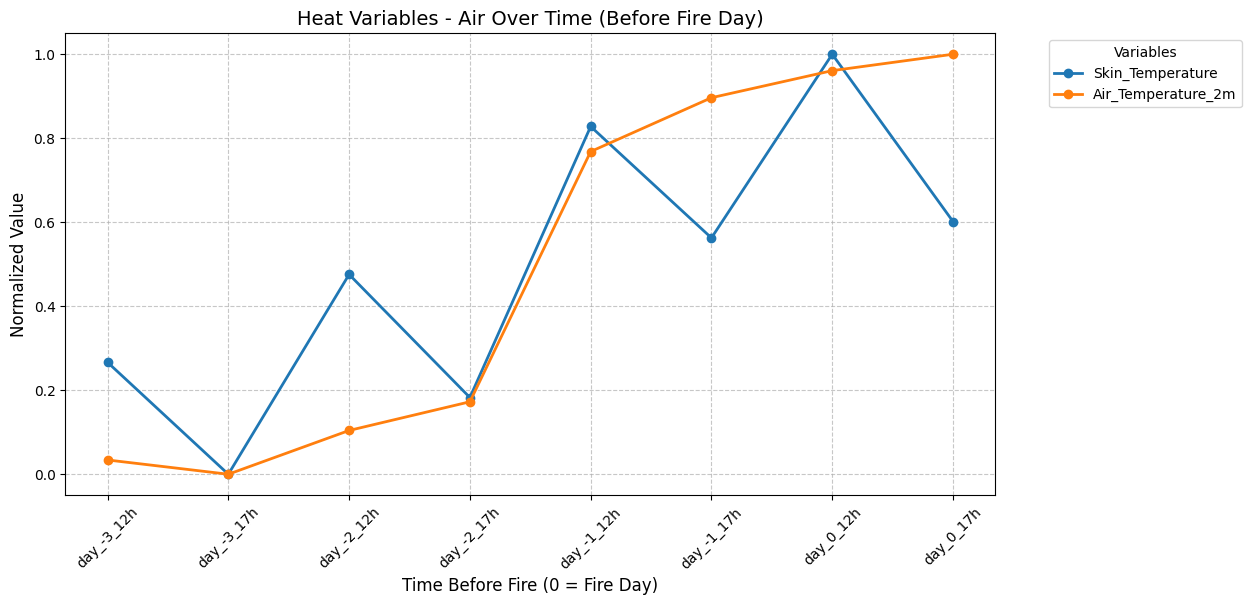

In [40]:
plot_variable_group(df_mean_normalized_climate_time_reversed, "Heat Variables - Air", [
        "Skin_Temperature", "Air_Temperature_2m"
    ])

<Figure size 1200x600 with 0 Axes>

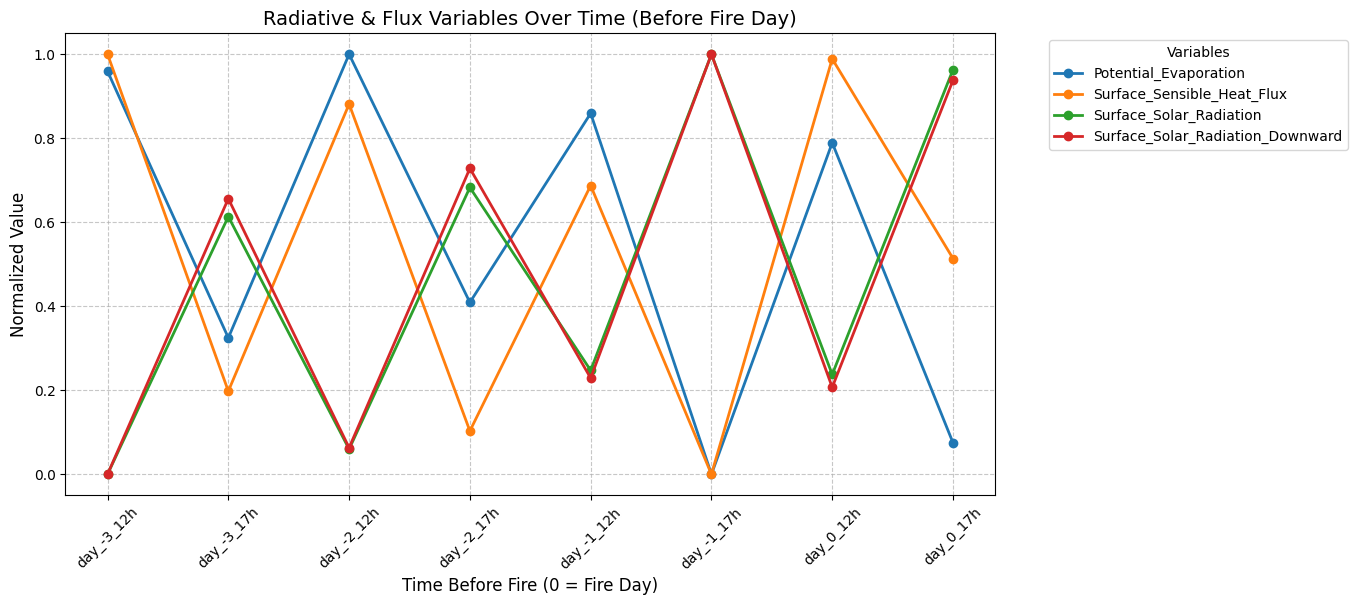

In [41]:
plot_variable_group(df_mean_normalized_climate_time_reversed, "Radiative & Flux Variables",[
        "Potential_Evaporation", "Surface_Solar_Radiation", "Surface_Solar_Radiation_Downward",
        "Surface_Sensible_Heat_Flux"
    ])

<Figure size 1200x600 with 0 Axes>

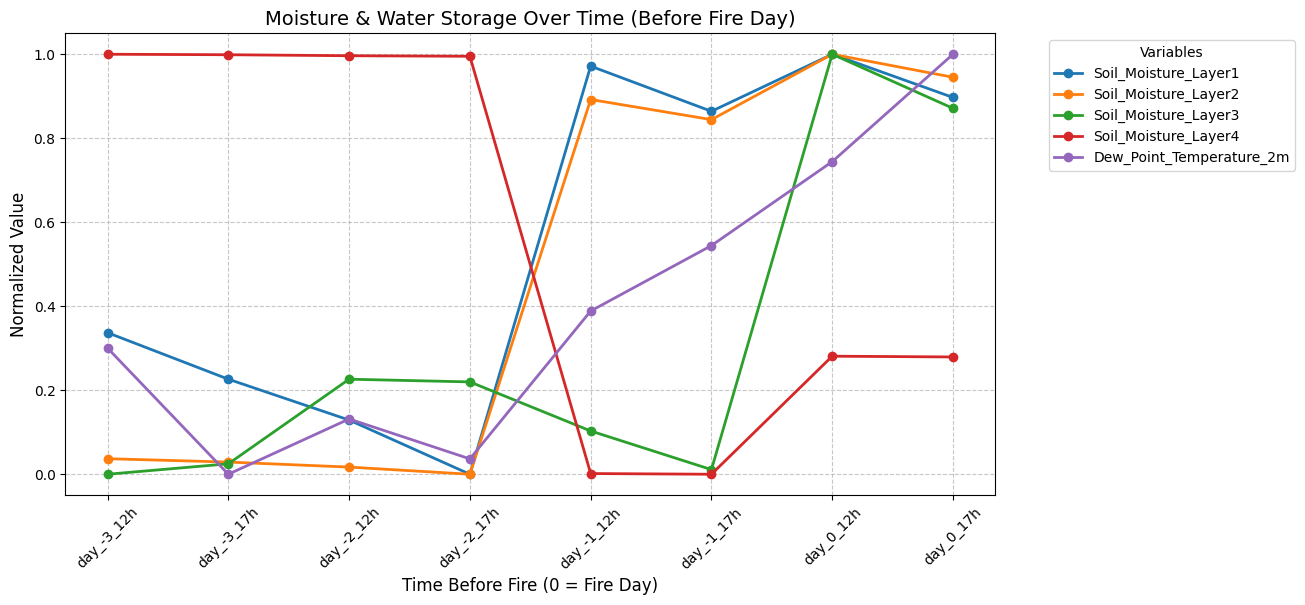

In [42]:
plot_variable_group(df_mean_normalized_climate_time_reversed, "Moisture & Water Storage",[
        "Soil_Moisture_Layer1", "Soil_Moisture_Layer2", "Soil_Moisture_Layer3",
        "Soil_Moisture_Layer4", "Dew_Point_Temperature_2m"
    ])

<Figure size 1200x600 with 0 Axes>

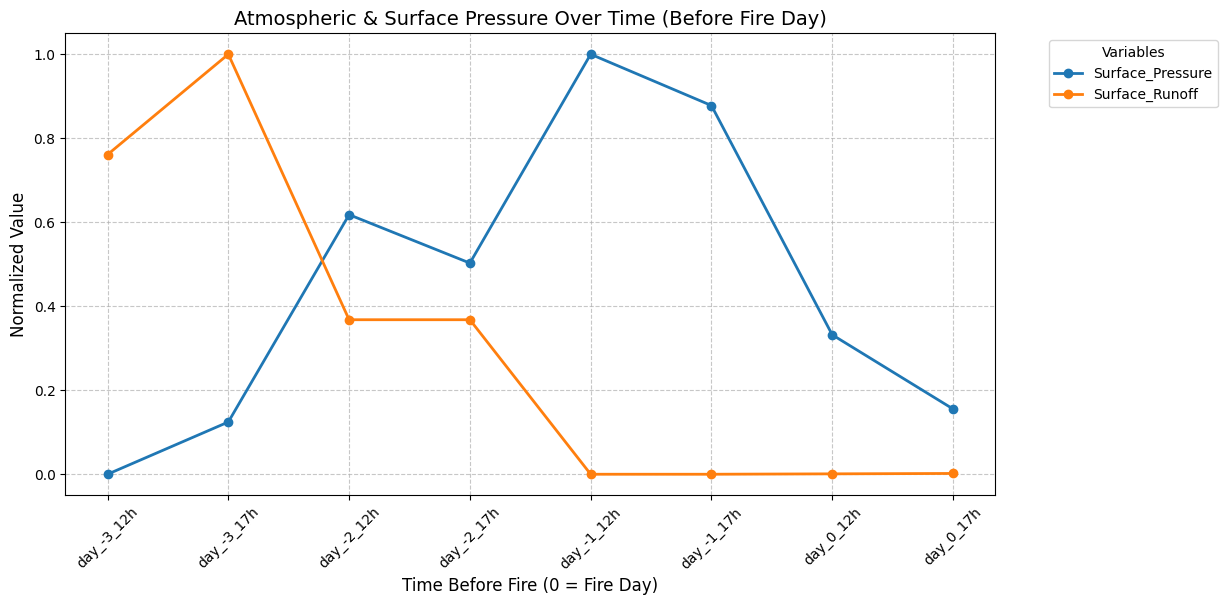

In [43]:
plot_variable_group(df_mean_normalized_climate_time_reversed, "Atmospheric & Surface Pressure", [
        "Surface_Pressure", "Surface_Runoff"
    ])

<Figure size 1200x600 with 0 Axes>

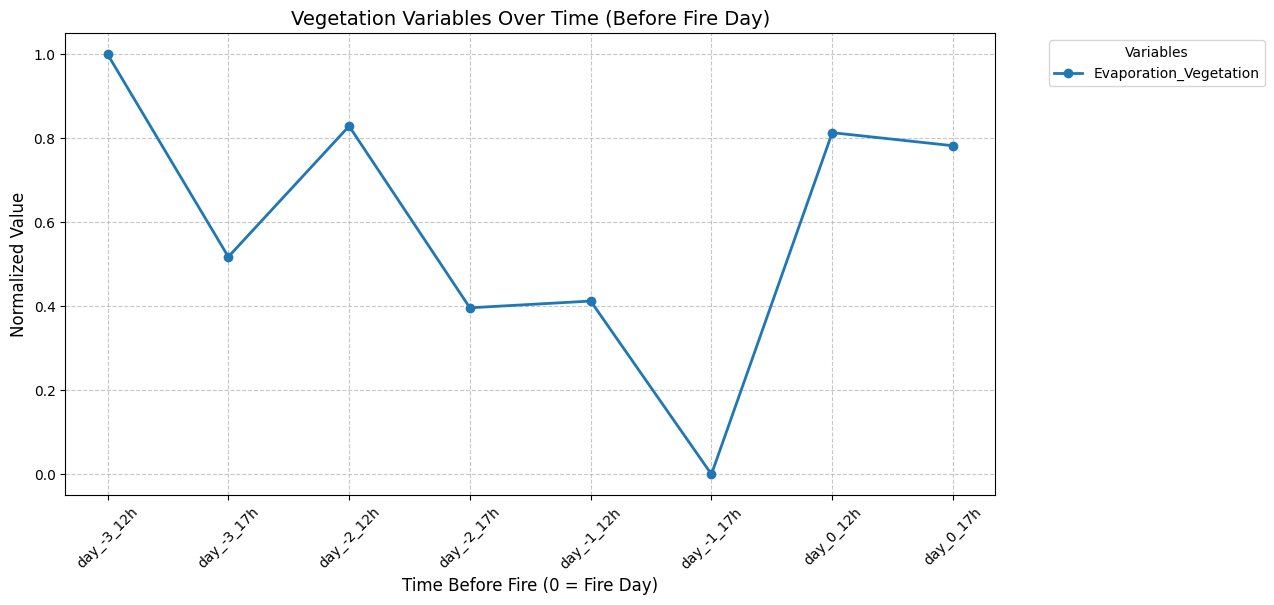

In [58]:
plot_variable_group(df_mean_normalized_climate_time_reversed, "Vegetation Variables", [
        "Evaporation_Vegetation"
    ])